# Corona Virus Exploratory Analysis and Modeling 

![](https://cdn.cnn.com/cnnnext/dam/assets/200130165125-corona-virus-cdc-image-super-tease.jpg)

# 1. Import Library

In [1]:
# System
import sys
import os
import operator
import argparse
import itertools

# Time
import time
import datetime
from datetime import datetime
from time import gmtime, strftime
from pytz import timezone

# Numerical Data
import random
import numpy as np 
import pandas as pd

# Tools
import shutil
from glob import glob
from tqdm import tqdm
import gc

# NLP
import re

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


# Deep Learning - Keras -  Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning - Keras - Model
import keras
from keras import models
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential

# Deep Learning - Keras - Layers
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPool2D, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D

from keras.regularizers import l2

# Deep Learning - Keras - Pretrained Models
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

from keras.applications.nasnet import preprocess_input

# Deep Learning - Keras - Model Parameters and Evaluation Metrics
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

# Deep Learning - Keras - Visualisation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
# from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Deep Learning - TensorFlow
import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

import seaborn as sns

from mlxtend.plotting import plot_confusion_matrix


from wordcloud import WordCloud

# Image
import cv2
from PIL import Image

from IPython.display import display
from IPython.core.display import HTML


# np.random.seed(42)

%matplotlib inline

# Input data
print(os.listdir("../input/"))

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['corona-virus-time-series-dataset']


### Time of last edit

In [2]:
def print_time():
    fmt = "%a, %d %B %Y %H:%M:%S %Z%z"
    
    pacific = timezone('US/Pacific')
    
    loc_dt = datetime.now(pacific)
    
    time_str = loc_dt.strftime(fmt)
    
    print("Pacific Time" + " : " + time_str)
    
    return time_str
    

In [3]:
def format_date_columns(data_cols):
    data_cols_new_format = []
    data_cols_map = {}
    
    for d in data_cols:
        new_d = datetime.strftime(datetime.strptime(d, '%m/%d/%y'),'%b %d')
        data_cols_map[d] = new_d
        data_cols_new_format.append(new_d)
    
    return data_cols_new_format, data_cols_map

In [4]:
cur_time_str = print_time()

Pacific Time : Tue, 31 March 2020 17:02:54 PDT-0700


# 2. Read Data

In [5]:
input_dir = "../input/corona-virus-time-series-dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
# input_dir = "../input/novel-corona-virus-2019-dataset/"

In [6]:
os.listdir(input_dir)

['time_series_covid19_confirmed_US.csv',
 'time_series_covid19_recovered_global.csv',
 'time_series_covid19_deaths_global.csv',
 'time_series_covid19_deaths_US.csv',
 'time_series_covid19_confirmed_global.csv']

In [7]:
time_series_covid19_confirmed_global = pd.read_csv(input_dir + "time_series_covid19_confirmed_global.csv")
time_series_covid19_recovered_global = pd.read_csv(input_dir + "time_series_covid19_recovered_global.csv")
time_series_covid19_deaths_global    = pd.read_csv(input_dir + "time_series_covid19_deaths_global.csv")

time_series_covid19_confirmed_US = pd.read_csv(input_dir + "time_series_covid19_confirmed_US.csv")
# time_series_covid19_recovered_global = pd.read_csv(input_dir + "time_series_covid19_recovered_global.csv")
time_series_covid19_deaths_US    = pd.read_csv(input_dir + "time_series_covid19_deaths_US.csv")


# time_series_covid_19_confirmed = pd.read_csv(input_dir + "time_series_covid_19_confirmed.csv")
# time_series_covid_19_recovered = pd.read_csv(input_dir + "time_series_covid_19_recovered.csv")
# time_series_covid_19_deaths    = pd.read_csv(input_dir + "time_series_covid_19_deaths.csv")

# 3. Data Preprocessing

In [8]:
columns = time_series_covid19_confirmed_global.columns.tolist()
location_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
location_long_lat_columns = ['Lat', 'Long']
location_name_cols = ['Country/Region', 'Province/State']

data_cols = [c for c in columns if c not in location_columns]

count_days = len(data_cols)

Change date format to string

In [9]:
data_cols_new_format, data_cols_map = format_date_columns(data_cols)

# data_cols_new_format = data_cols

last_day = data_cols_new_format[-1]
prev_day = data_cols_new_format[-2]

new_cols = location_name_cols + [last_day]

In [10]:
time_series_covid19_confirmed_global.rename(columns=data_cols_map, inplace=True)
time_series_covid19_recovered_global.rename(columns=data_cols_map, inplace=True)
time_series_covid19_deaths_global.rename(columns=data_cols_map, inplace=True)

In [11]:
def time_series_data(df=None, data_cols=None):
    series_data = {}
    
    series_data["Original"] = df[data_cols]
    
    series_data["Add"] = df[data_cols].sum().copy()
    series_data["Add"][data_cols] = series_data["Add"][data_cols].astype(int)

    series_data["Mul"] = df[data_cols].sum().copy()
    series_data["Mul"][data_cols] = series_data["Mul"][data_cols].astype(float)

    for i in range(count_days - 1, 0, -1):    
        series_data["Add"][data_cols[i]] = series_data["Add"][data_cols[i]] - series_data["Add"][data_cols[i - 1]]
        series_data["Mul"][data_cols[i]] = series_data["Mul"][data_cols[i]] / series_data["Mul"][data_cols[i - 1]]

    series_data["Percent Inc"] = series_data["Mul"] * 100 - 100

    series_data["Inc"] = series_data["Add"].copy()
    series_data["Inc"][data_cols] = series_data["Inc"][data_cols].astype(float)

    for i in range(count_days - 1, 0, -1):    
        series_data["Inc"][data_cols[i]] = series_data["Inc"][data_cols[i]] / series_data["Inc"][data_cols[i - 1]]
        
    return series_data

def time_series_data_main(df_confirmed=None, df_recovered=None, df_death=None, data_cols=None):
    series_data_main = {}
    
    series_data_main["Confirmed"] = time_series_data(df=df_confirmed, data_cols=data_cols)
    series_data_main["Recovered"] = time_series_data(df=df_recovered, data_cols=data_cols)
    series_data_main["Death"]     = time_series_data(df=df_death, data_cols=data_cols)
    
    return series_data_main

In [12]:
def total_stats(country="", state="", extra=False, df_confirmed=None, df_recovered=None, df_death=None, data_cols=None, show_stats=False):
    stats = {}
    
    if country!="Global" and country!="" and state=="":    
        df_confirmed = df_confirmed[df_confirmed["Country/Region"]==country]
        df_recovered = df_recovered[df_recovered["Country/Region"]==country]
        df_death   = df_death[df_death["Country/Region"]==country]
    elif country != "Global" and state!="":
        df_confirmed = df_confirmed[df_confirmed["Province/State"]==state]
        df_recovered = df_recovered[df_recovered["Province/State"]==state]
        df_death   = df_death[df_death["Province/State"]==state]
    
    if extra==True:
        stats["Series Data"] = time_series_data_main(df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols)
    
    
    stats["Confirmed"] = df_confirmed[data_cols_new_format].sum()
    stats["Recovered"] = df_recovered[data_cols_new_format].sum()
    stats["Death"]     = df_death[data_cols_new_format].sum()
    
    stats["Confirmed"] = df_confirmed.sum()
    stats["Recovered"] = df_recovered.sum()
    stats["Death"]     = df_death.sum()
    
    stats["total_confirmed"] = df_confirmed[last_day].sum()
    stats["total_recovered"] = df_recovered[last_day].sum()
    stats["total_death"] = df_death[last_day].sum()
    
    stats["new_confirmed"] = stats["total_confirmed"] - df_confirmed[prev_day].sum()
    stats["new_recovered"] = stats["total_recovered"] - df_recovered[prev_day].sum()
    stats["new_death"] = stats["total_death"] - df_death[prev_day].sum()

    stats["total_closed"] = stats["total_recovered"] + stats["total_death"]
    stats["total_active"] = stats["total_confirmed"] - stats["total_closed"]

    stats["persistence_rate"] = (stats["total_active"] / stats["total_confirmed"]) * 100
    stats["fatality_rate"] = (stats["total_death"] / stats["total_confirmed"]) * 100
    stats["recovery_rate"] = (stats["total_recovered"] / stats["total_confirmed"]) * 100

    stats["net_fatality_rate"] = (stats["total_death"] / stats["total_closed"]) * 100
    stats["net_recovery_rate"] = (stats["total_recovered"] / stats["total_closed"]) * 100
    
    
    stats["confirmed_growth_percentile_mean"] = stats["Series Data"]["Confirmed"]["Percent Inc"][1:].mean()
    stats["confirmed_growth_percentile_std"] = stats["Series Data"]["Confirmed"]["Percent Inc"][1:].std()
    stats["confirmed_growth_mean"] = stats["Series Data"]["Confirmed"]["Inc"][1:].mean()
    stats["confirmed_growth_std"] = stats["Series Data"]["Confirmed"]["Inc"][1:].std()
    
    stats["recovered_growth_percentile_mean"] = stats["Series Data"]["Recovered"]["Percent Inc"][1:].mean()
    stats["recovered_growth_percentile_std"] = stats["Series Data"]["Recovered"]["Percent Inc"][1:].std()
    stats["recovered_growth_mean"] = stats["Series Data"]["Recovered"]["Inc"][1:].mean()
    stats["recovered_growth_std"] = stats["Series Data"]["Recovered"]["Inc"][1:].std()
    
    stats["death_growth_percentile_mean"] = stats["Series Data"]["Death"]["Percent Inc"][1:].mean()
    stats["death_growth_percentile_std"] = stats["Series Data"]["Death"]["Percent Inc"][1:].std()
    stats["death_growth_mean"] = stats["Series Data"]["Death"]["Inc"][1:].mean()
    stats["death_growth_std"] = stats["Series Data"]["Death"]["Inc"][1:].std()
 
    
    if show_stats==True:
        print(" ", state, " ", country)
        print("*"*70)
        print("*"*70)


        print(" Current")
        print("-"*70)

        print(" Total Confirmed                                    : %d" % (stats["total_confirmed"]))
        print(" Total Recovered                                    : %d" % (stats["total_recovered"]))
        print(" Total Death                                        : %d" % (stats["total_death"]))
        print("-"*70)
        print("\n")

        print(" New Cases")
        print("-"*70)

        print(" New Confirmed                                      : %d" % (stats["new_confirmed"]))
        print(" New Recovered                                      : %d" % (stats["new_recovered"]))
        print(" New Deaths                                         : %d" % (stats["new_death"]))
        print("-"*70)
        print("\n")

        print(" Other Totals")
        print("-"*70)

        print(" Total Active (Confirmed - (Recovered + Deaths))    : %d" % (stats["total_active"]))
        print(" Total Closed (Recovered + Deaths)                  : %d" % (stats["total_closed"]))
        print("-"*70)
        print("\n")

        print(" Rates/Percentiles")
        print("-"*70)
        print(" Persistence Rate (Total Active / Total Confirmed)  : %.2f" % (stats["persistence_rate"]))
        print(" Fatality Rate (Total Death / Total Confirmed)      : %.2f" % (stats["fatality_rate"]))
        print(" Recovery Rate (Total Recovered / Total Confirmed)  : %.2f" % (stats["recovery_rate"]))

        print("\n")
        print(" Net Fatality Rate (Total Death / Total Closed)     : %.2f" % (stats["net_fatality_rate"]))
        print(" Net Recovery Rate (Total Recovered / Total Closed) : %.2f" % (stats["net_recovery_rate"]))
        print("-"*70)
        print("\n\n")

        print(" Growth Factors")
        print("-"*80)
        print("\n")
        print(" Confirmed")
        print("-"*80)
        print(" Average Growth Percentile (((Current Day - Previous Day)/Previous Day) *100): %.2f" % (stats["confirmed_growth_percentile_mean"]))
        print(" Standard Deviation of Growth Percentile                                     : %.2f" % (stats["confirmed_growth_percentile_std"]))
        print(" Average Growth (Current Day / Previous Day)                                 : %.2f" % (stats["confirmed_growth_mean"]))
        print(" Standard Deviation of Growth                                                : %.2f" % (stats["confirmed_growth_std"]))
        print("-"*80)    
        print("\n")

        print(" Recovered")
        print("-"*80)
        print(" Average Growth Percentile (((Current Day - Previous Day)/Previous Day) *100): %.2f" % (stats["recovered_growth_percentile_mean"]))
        print(" Standard Deviation of Growth Percentile                                     : %.2f" % (stats["recovered_growth_percentile_std"]))
        print(" Average Growth (Current Day / Previous Day)                                 : %.2f" % (stats["recovered_growth_mean"]))
        print(" Standard Deviation of Growth                                                : %.2f" % (stats["recovered_growth_std"]))
        print("-"*80)
        print("\n")


        print(" Death")
        print("-"*80)
        print(" Average Growth Percentile (((Current Day - Previous Day)/Previous Day) *100): %.2f" % (stats["death_growth_percentile_mean"]))
        print(" Standard Deviation of Growth Percentile                                     : %.2f" % (stats["death_growth_percentile_std"]))
        print(" Average Growth (Current Day / Previous Day)                                 : %.2f" % (stats["death_growth_mean"]))
        print(" Standard Deviation of Growth                                                : %.2f" % (stats["death_growth_std"]))
        print("-"*80)

    return stats

In [13]:
!pip install itables
!pip install countryinfo


import itables.interactive
from itables import show

from countryinfo import CountryInfo

  Created wheel for itables: filename=itables-0.2.1-py3-none-any.whl size=10700 sha256=b4f40608684fa7a96a4a75ef769ff9b740947c4f148cd57a7d4a6f4fb8678b6a
  Stored in directory: /root/.cache/pip/wheels/40/4a/a4/8710dfd160c96d255bf27ff61309b9558c66941ab638738b0e
Successfully built itables
     |████████████████████████████████| 202 kB 6.4 MB/s 
  Created wheel for countryinfo: filename=countryinfo-0.1.0-py3-none-any.whl size=592038 sha256=eba73036b7edfafb47ccbfc2efc950d07c82a269f108c080194d27c493ca867c
  Stored in directory: /root/.cache/pip/wheels/2d/f1/6a/72da4985c410aa7c424fd04d3bb6337a1552035b090d9cb8db
Successfully built countryinfo


<IPython.core.display.Javascript object>

In [14]:
country_name_map = {
    "Andorra":"NA",
    "Bahamas": "The Bahamas",
    "Burma": "NA",
    "Cabo Verde": "NA",
    "Congo (Brazzaville)": "NA",
    "Congo (Kinshasa)": "Democratic Republic of the Congo",
    "Cote d'Ivoire": "NA",
    "Czechia": "NA",
    "Diamond Princess": "NA",
    "Eswatini": "NA",
    "Gambia": "The Gambia",
    "Holy See": "NA",
    "Korea, South": "South Korea",
    "Kosovo": "NA",
    "Montenegro": "NA",
    "North Macedonia": "NA",
    "Serbia": "NA",
    "Taiwan*": "Taiwan",
    "Timor-Leste": "NA",
    "US": "united states",
    "West Bank and Gaza": "NA"}

In [15]:
def country_info(country, property_name):
    if country not in country_name_map:
        try:
            return CountryInfo(country).info()[property_name]
        except:
            return "NA"
    elif country_name_map[country]!="NA":
        return CountryInfo(country_name_map[country]).info()[property_name]
    else:
        return "NA"

In [16]:
def add_property(df):
    new_df = df.copy()
    new_df["Region"] = new_df["Country/Region"].apply(lambda x: country_info(x, "region"))
    new_df["Subregion"] = new_df["Country/Region"].apply(lambda x: country_info(x, "subregion"))
    new_df["Population"] = new_df["Country/Region"].apply(lambda x: country_info(x, "population"))
    new_df["Area"] = new_df["Country/Region"].apply(lambda x: country_info(x, "area"))
    # new_df["Timezones"] = new_df["Country/Region"].apply(lambda x: country_info(x, "timezones"))
    # new_df["Currencies"] = new_df["Country/Region"].apply(lambda x: country_info(x, "currencies"))
    # new_df["Languages"] = new_df["Country/Region"].apply(lambda x: country_info(x, "languages"))
    
    cols = new_df.columns.tolist()
    new_df = new_df[[cols[1]] + [cols[0]] + cols[-4:] + cols[2:4]  + cols[4:-4]]
    
    return new_df

In [17]:
time_series_covid_19_confirmed = add_property(time_series_covid19_confirmed_global)
time_series_covid_19_recovered = add_property(time_series_covid19_recovered_global)
time_series_covid_19_deaths    = add_property(time_series_covid19_deaths_global)

In [18]:
location_columns   = ['Province/State', 'Country/Region', 'Region', 'Subregion', 'Population', 'Area', 'Lat', 'Long']
location_name_cols = ['Country/Region', 'Province/State', 'Region', 'Subregion', 'Population', 'Area']

In [19]:
time_series_covid_19_confirmed.rename(columns=data_cols_map, inplace=True)
time_series_covid_19_recovered.rename(columns=data_cols_map, inplace=True)
time_series_covid_19_deaths.rename(columns=data_cols_map, inplace=True)

In [20]:
time_series_covid_19_confirmed.to_csv("time_series_covid_19_confirmed_new.csv")
time_series_covid_19_recovered.to_csv("time_series_covid_19_recovered_new.csv")
time_series_covid_19_deaths.to_csv("time_series_covid_19_deaths_new.csv")

In [21]:
country_list = time_series_covid_19_confirmed['Country/Region'].unique().tolist()
country_list.sort()

state_list = time_series_covid_19_confirmed['Province/State'].unique().tolist()
# state_list.sort()

In [22]:
last_confirmed_df = time_series_covid_19_confirmed[location_name_cols + [last_day]].copy()
last_confirmed_df.rename(columns = {last_day: "Confirmed"}, inplace=True)

last_add_confirmed_df = time_series_covid_19_confirmed[location_name_cols + [prev_day, last_day]].copy()
last_add_confirmed_df["New Confirmed"] = last_add_confirmed_df[last_day] - last_add_confirmed_df[prev_day]
last_add_confirmed_df.drop(columns = [prev_day, last_day], inplace=True)

last_recovered_df = time_series_covid_19_recovered[location_name_cols + [last_day]].copy()
last_recovered_df.rename(columns = {last_day: "Recovered"}, inplace=True)

last_add_recovered_df = time_series_covid_19_recovered[location_name_cols + [prev_day, last_day]].copy()
last_add_recovered_df["New Recovered"] = last_add_recovered_df[last_day] - last_add_recovered_df[prev_day]
last_add_recovered_df.drop(columns = [prev_day, last_day], inplace=True)

last_death_df = time_series_covid_19_deaths[location_name_cols + [last_day]].copy()
last_death_df.rename(columns = {last_day: "Death"}, inplace=True)

last_add_death_df = time_series_covid_19_deaths[location_name_cols + [prev_day, last_day]].copy()
last_add_death_df["New Death"] = last_add_death_df[last_day] - last_add_death_df[prev_day]
last_add_death_df.drop(columns = [prev_day, last_day], inplace=True)


In [23]:
result1 = last_confirmed_df.merge(last_add_confirmed_df, on = location_name_cols)
result2 = result1.merge(last_recovered_df, on = location_name_cols)
result3 = result2.merge(last_add_recovered_df, on = location_name_cols)
result4 = result3.merge(last_death_df, on = location_name_cols)
result = result4.merge(last_add_death_df, on = location_name_cols)

In [24]:
result ["Active"] = result["Confirmed"] - (result["Recovered"] + result["Death"])
result ["Closed"] = result["Recovered"] + result["Death"]

result["Persistence Rate"] = (result["Active"] / result["Confirmed"]) * 100
result["Fatality Rate"] = (result["Death"] / result["Confirmed"]) * 100
result["Recovery Rate"] = (result["Recovered"] / result["Confirmed"]) * 100

result["Net Recovery Rate"] = (result["Recovered"] / result["Closed"]) * 100
result["Net Fatality Rate"] = (result["Death"] / result["Closed"]) * 100

In [25]:
result.to_csv("result.csv")

In [26]:
show(result, paging=True)

,Country/Region,Province/State,Region,Subregion,Population,Area,Confirmed,New Confirmed,Recovered,New Recovered,Death,New Death,Active,Closed,Persistence Rate,Fatality Rate,Recovery Rate,Net Recovery Rate,Net Fatality Rate


In [27]:
country_cols = ['Country/Region', 'Region', 'Subregion', 'Population', 'Area', 'Confirmed', 
                'New Confirmed', 'Recovered', 'New Recovered','Death', 'New Death', 'Active', 'Closed']

country_group_by_cols = ['Country/Region', 'Region', 'Subregion', 'Population', 'Area']


result_country = result[country_cols].groupby(country_group_by_cols).sum().reset_index()


result_country["Persistence Rate"] = (result_country["Active"] / result_country["Confirmed"]) * 100
result_country["Fatality Rate"] = (result_country["Death"] / result_country["Confirmed"]) * 100
result_country["Recovery Rate"] = (result_country["Recovered"] / result_country["Confirmed"]) * 100
result_country["Net Recovery Rate"] = (result_country["Recovered"] / result_country["Closed"]) * 100
result_country["Net Fatality Rate"] = (result_country["Death"] / result_country["Closed"]) * 100

# result_country["Confirm per Population"] = (result_country["Confirmed"] / result_country["Population"]) * 100
# result_country["Death per Population"] = (result_country["Death"] / result_country["Population"]) * 100

In [28]:
result_country.to_csv("result_country.csv")

In [29]:
show(result_country, paging=True)

Country/Region,Region,Subregion,Population,Area,Confirmed,New Confirmed,Recovered,New Recovered,Death,New Death,Active,Closed,Persistence Rate,Fatality Rate,Recovery Rate,Net Recovery Rate,Net Fatality Rate


In [30]:
# subregion_cols = ['Region', 'Subregion', 'Population', 'Area', 'Confirmed', 'New Confirmed', 'Recovered',
#                   'New Recovered','Death', 'New Death', 'Active', 'Closed']

subregion_group_by_cols = ['Subregion']

result_subregion = result.groupby(subregion_group_by_cols).sum().reset_index()

result_subregion["Persistence Rate"] = (result_subregion["Active"] / result_subregion["Confirmed"]) * 100
result_subregion["Fatality Rate"] = (result_subregion["Death"] / result_subregion["Confirmed"]) * 100
result_subregion["Recovery Rate"] = (result_subregion["Recovered"] / result_subregion["Confirmed"]) * 100
result_subregion["Net Recovery Rate"] = (result_subregion["Recovered"] / result_subregion["Closed"]) * 100
result_subregion["Net Fatality Rate"] = (result_subregion["Death"] / result_subregion["Closed"]) * 100

In [31]:
result_subregion.to_csv("result_subregion.csv")

In [32]:
show(result_subregion, paging=True)

Subregion,Confirmed,New Confirmed,Recovered,New Recovered,Death,New Death,Active,Closed,Persistence Rate,Fatality Rate,Recovery Rate,Net Recovery Rate,Net Fatality Rate


In [33]:
# region_cols = ['Region', 'Population', 'Area', 'Confirmed', 'New Confirmed', 'Recovered',
#                   'New Recovered','Death', 'New Death', 'Active', 'Closed']

region_group_by_cols = ['Region']

result_region = result.groupby(region_group_by_cols).sum().reset_index()


result_region["Persistence Rate"] = (result_region["Active"] / result_region["Confirmed"]) * 100
result_region["Fatality Rate"] = (result_region["Death"] / result_region["Confirmed"]) * 100
result_region["Recovery Rate"] = (result_region["Recovered"] / result_region["Confirmed"]) * 100
result_region["Net Fatality Rate"] = (result_region["Death"] / result_region["Closed"]) * 100

In [34]:
result_region.to_csv("result_region.csv")

In [35]:
show(result_region, paging=True)

Region,Confirmed,New Confirmed,Recovered,New Recovered,Death,New Death,Active,Closed,Persistence Rate,Fatality Rate,Recovery Rate,Net Recovery Rate,Net Fatality Rate


In [36]:
df_confirmed = time_series_covid19_confirmed_global
df_recovered = time_series_covid19_recovered_global
df_death = time_series_covid19_deaths_global

data_cols = data_cols_new_format

stats_global = total_stats(country="Global", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

     Global
**********************************************************************
**********************************************************************
 Current
----------------------------------------------------------------------
 Total Confirmed                                    : 782365
 Total Recovered                                    : 164566
 Total Death                                        : 37582
----------------------------------------------------------------------


 New Cases
----------------------------------------------------------------------
 New Confirmed                                      : 62248
 New Recovered                                      : 15484
 New Deaths                                         : 3657
----------------------------------------------------------------------


 Other Totals
----------------------------------------------------------------------
 Total Active (Confirmed - (Recovered + Deaths))    : 580217
 Total Closed (Recovered + Deat

In [37]:
# stats_US = total_stats(country="US", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

In [38]:
# stats_US = total_stats(country="Bangladesh", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

In [39]:
# stats_US = total_stats(country="Italy", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

In [40]:
# stats_US = total_stats(country="Spain", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

In [41]:
# stats_US = total_stats(country="China", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

In [42]:
# stats_US = total_stats(country="Iran", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

In [43]:
# stats_US = total_stats(country="India", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

In [44]:
# stats_US = total_stats(country="Pakistan", state="", extra=True, df_confirmed=df_confirmed, df_recovered=df_recovered, df_death=df_death, data_cols=data_cols, show_stats=True)

# 4. Visualization

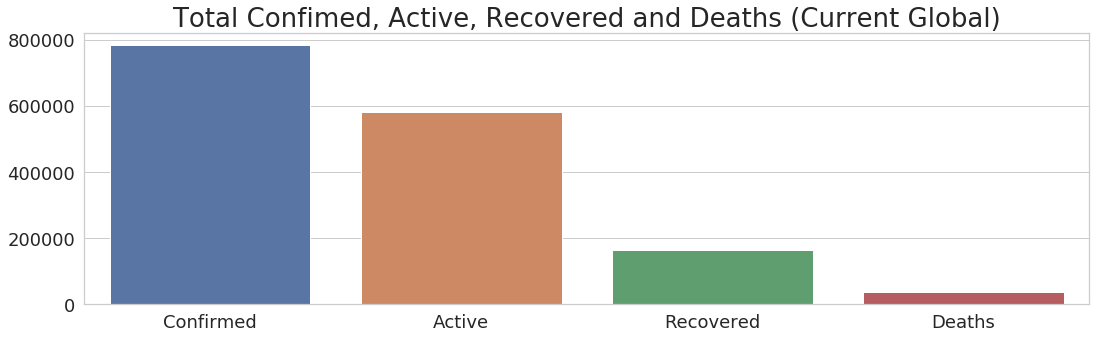

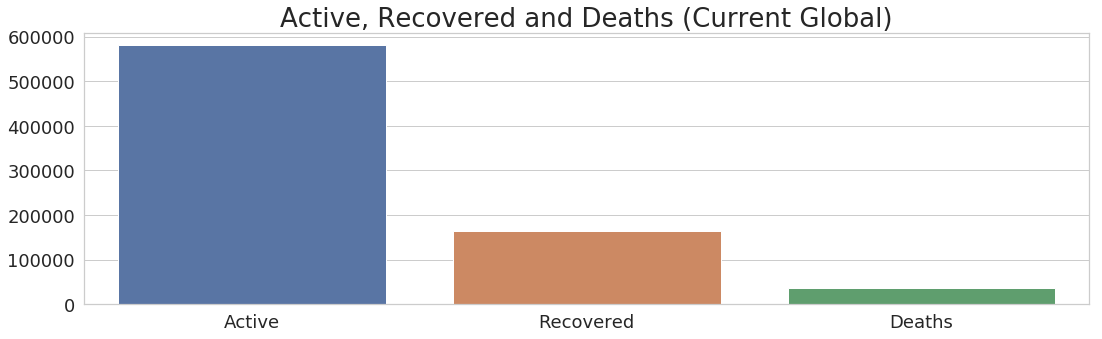

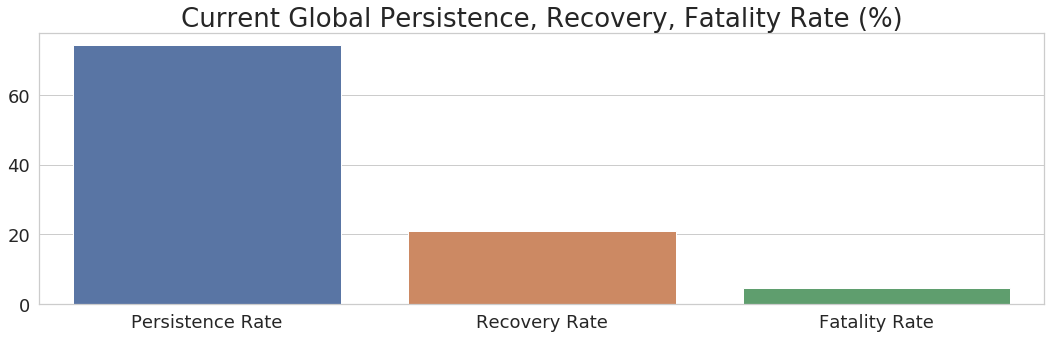

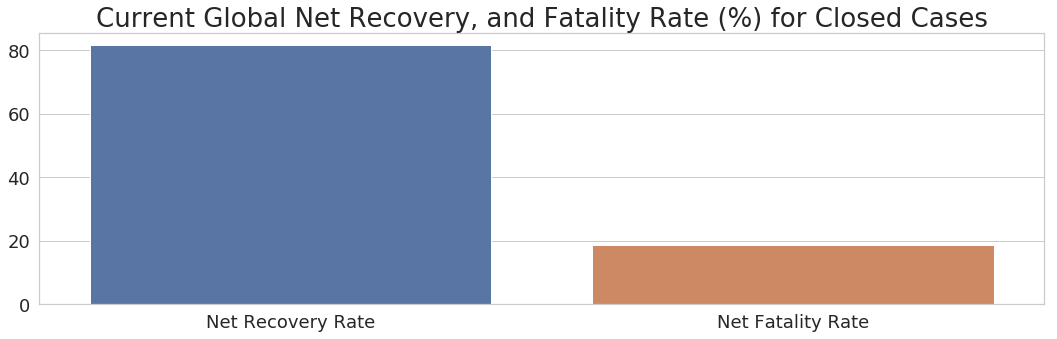

In [45]:
sns.set(style="whitegrid")

ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

figsize   = (18, 5)
params    = {'figure.figsize' : figsize,
             'axes.labelsize' : labelsize,
             'axes.titlesize' : titlesize,
             'xtick.labelsize': ticksize,
             'ytick.labelsize': ticksize}

plt.rcParams.update(params)



data = [stats_global["total_confirmed"], stats_global["total_active"], stats_global["total_recovered"], stats_global["total_death"]]
labels = ["Confirmed", "Active", "Recovered", "Deaths"]

title    = "Total Confimed, Active, Recovered and Deaths (Current Global)"

# xlabel   = ""
# ylabel   = "Count"
# rotation = 90


sns.barplot(x=labels, y=data)
plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
plt.show() 
    
    

data = [stats_global["total_active"], stats_global["total_recovered"], stats_global["total_death"]]
labels = ["Active", "Recovered", "Deaths"]

title = "Active, Recovered and Deaths (Current Global)"

# xlabel   = ""
# ylabel   = "Count"
# rotation = 90


sns.barplot(x=labels, y=data)
plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
plt.show() 
   


data = [stats_global["persistence_rate"], stats_global["recovery_rate"], stats_global["fatality_rate"]]
labels = ["Persistence Rate", "Recovery Rate", "Fatality Rate"]

title = "Current Global Persistence, Recovery, Fatality Rate (%)"

# xlabel   = ""
# ylabel   = "Count"
# rotation = 90


sns.barplot(x=labels, y=data)
plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
plt.show()



data = [stats_global["net_recovery_rate"], stats_global["net_fatality_rate"]]
labels = ["Net Recovery Rate", "Net Fatality Rate"]

title = "Current Global Net Recovery, and Fatality Rate (%) for Closed Cases"

# xlabel   = ""
# ylabel   = "Count"
# rotation = 90


sns.barplot(x=labels, y=data)
plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
plt.show()

In [46]:
# time_series_covid_19_confirmed.info()
time_series_covid_19_confirmed.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_confirmed.fillna("NA", inplace=True)
# time_series_covid_19_confirmed.head()

In [47]:
# time_series_covid_19_recovered.info()
time_series_covid_19_recovered.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_recovered.fillna("NA", inplace=True)
# time_series_covid_19_recovered.head()

In [48]:
# time_series_covid_19_deaths.info()
time_series_covid_19_deaths.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_deaths.fillna("NA", inplace=True)
# time_series_covid_19_deaths.head()

In [49]:
data_cols = data_cols_new_format

In [50]:
confirmed_total_add = time_series_covid_19_confirmed[data_cols].sum().copy()
confirmed_total_add[data_cols] = confirmed_total_add[data_cols].astype(int)

confirmed_total_mul = time_series_covid_19_confirmed[data_cols].sum().copy()
confirmed_total_mul[data_cols] = confirmed_total_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_total_add[data_cols[i]] = confirmed_total_add[data_cols[i]] - confirmed_total_add[data_cols[i - 1]]
    confirmed_total_mul[data_cols[i]] = confirmed_total_mul[data_cols[i]] / confirmed_total_mul[data_cols[i - 1]]


confirmed_total_percent_inc = (confirmed_total_mul - 1)*100

confirmed_total_inc = confirmed_total_add.copy()
confirmed_total_inc[data_cols] = confirmed_total_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_total_inc[data_cols[i]] = confirmed_total_inc[data_cols[i]] / confirmed_total_inc[data_cols[i - 1]]

In [51]:
confirmed_add = time_series_covid_19_confirmed[data_cols].copy()
confirmed_add[data_cols] = confirmed_add[data_cols].astype(int)

confirmed_mul = time_series_covid_19_confirmed[data_cols].sum().copy()
confirmed_mul[data_cols] = confirmed_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_add[data_cols[i]] = confirmed_add[data_cols[i]] - confirmed_add[data_cols[i - 1]]
    confirmed_mul[data_cols[i]] = confirmed_mul[data_cols[i]] / confirmed_mul[data_cols[i - 1]]


confirmed_percent_inc = (confirmed_mul - 1)*100


confirmed_inc = confirmed_total_add.copy()
confirmed_total_inc[data_cols] = confirmed_total_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_total_inc[data_cols[i]] = confirmed_total_inc[data_cols[i]] / confirmed_total_inc[data_cols[i - 1]]

In [52]:
time_series_covid_19_confirmed_country = time_series_covid_19_confirmed.drop(columns=location_long_lat_columns)
time_series_covid_19_confirmed_country = time_series_covid_19_confirmed_country.groupby(['Country/Region']).sum()
# time_series_covid_19_confirmed_country.head()

In [53]:
confirmed_country_add = time_series_covid_19_confirmed_country[data_cols].copy()
confirmed_country_add[data_cols] = confirmed_country_add[data_cols].astype(int)

confirmed_country_mul = time_series_covid_19_confirmed_country[data_cols].copy()
confirmed_country_mul[data_cols] = confirmed_country_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_country_add[data_cols[i]] = confirmed_country_add[data_cols[i]] - confirmed_country_add[data_cols[i - 1]]
    confirmed_country_mul[data_cols[i]] = confirmed_country_mul[data_cols[i]] / confirmed_country_mul[data_cols[i - 1]]

confirmed_country_percent_inc = (confirmed_country_mul - 1)*100

confirmed_country_inc = confirmed_country_add.copy()
confirmed_country_inc[data_cols] = confirmed_country_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_country_inc[data_cols[i]] = confirmed_country_inc[data_cols[i]] / confirmed_country_inc[data_cols[i - 1]]

In [54]:
recovered_total_add = time_series_covid_19_recovered[data_cols].sum().copy()
recovered_total_add[data_cols] = recovered_total_add[data_cols].astype(int)

recovered_total_mul = time_series_covid_19_recovered[data_cols].sum().copy()
recovered_total_mul[data_cols] = recovered_total_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    recovered_total_add[data_cols[i]] = recovered_total_add[data_cols[i]] - recovered_total_add[data_cols[i - 1]]
    recovered_total_mul[data_cols[i]] = recovered_total_mul[data_cols[i]] / recovered_total_mul[data_cols[i - 1]]


recovered_total_percent_inc = (recovered_total_mul - 1)*100

recovered_total_inc = recovered_total_add.copy()
recovered_total_inc[data_cols] = recovered_total_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    recovered_total_inc[data_cols[i]] = recovered_total_inc[data_cols[i]] / recovered_total_inc[data_cols[i - 1]]

In [55]:
time_series_covid_19_recovered_country = time_series_covid_19_recovered.drop(columns=location_long_lat_columns)
time_series_covid_19_recovered_country = time_series_covid_19_recovered_country.groupby(['Country/Region']).sum()
# time_series_covid_19_recovered_country.head()

In [56]:
recovered_country_add = time_series_covid_19_recovered_country[data_cols].copy()
recovered_country_add[data_cols] = recovered_country_add[data_cols].astype(int)

recovered_country_mul = time_series_covid_19_recovered_country[data_cols].copy()
recovered_country_mul[data_cols] = recovered_country_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    recovered_country_add[data_cols[i]] = recovered_country_add[data_cols[i]] - recovered_country_add[data_cols[i - 1]]
    recovered_country_mul[data_cols[i]] = recovered_country_mul[data_cols[i]] / recovered_country_mul[data_cols[i - 1]]


recovered_country_percent_inc = (recovered_country_mul - 1)*100

recovered_country_inc = recovered_country_add.copy()
recovered_country_inc[data_cols] = recovered_country_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    recovered_country_inc[data_cols[i]] = recovered_country_inc[data_cols[i]] / recovered_country_inc[data_cols[i - 1]]

In [57]:
death_total_add = time_series_covid_19_deaths[data_cols].sum().copy()
death_total_add[data_cols] = death_total_add[data_cols].astype(int)

death_total_mul = time_series_covid_19_deaths[data_cols].sum().copy()
death_total_mul[data_cols] = death_total_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    death_total_add[data_cols[i]] = death_total_add[data_cols[i]] - death_total_add[data_cols[i - 1]]
    death_total_mul[data_cols[i]] = death_total_mul[data_cols[i]] / death_total_mul[data_cols[i - 1]]


death_total_percent_inc = (death_total_mul - 1)*100


death_total_inc = death_total_add.copy()
death_total_inc[data_cols] = death_total_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    death_total_inc[data_cols[i]] = death_total_inc[data_cols[i]] / death_total_inc[data_cols[i - 1]]

In [58]:
time_series_covid_19_deaths_country = time_series_covid_19_deaths.drop(columns=location_long_lat_columns)
time_series_covid_19_deaths_country = time_series_covid_19_deaths_country.groupby(['Country/Region']).sum()
# time_series_covid_19_deaths_country.head()

In [59]:
death_country_add = time_series_covid_19_deaths_country[data_cols].copy()
death_country_add[data_cols] = death_country_add[data_cols].astype(int)

death_country_mul = time_series_covid_19_deaths_country[data_cols].copy()
death_country_mul[data_cols] = death_country_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    death_country_add[data_cols[i]] = death_country_add[data_cols[i]] - death_country_add[data_cols[i - 1]]
    death_country_mul[data_cols[i]] = death_country_mul[data_cols[i]] / death_country_mul[data_cols[i - 1]]


death_country_percent_inc = (death_country_mul - 1)*100

death_country_inc = time_series_covid_19_deaths_country[data_cols].copy()
death_country_inc[data_cols] = death_country_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    death_country_inc[data_cols[i]] = death_country_inc[data_cols[i]] / death_country_inc[data_cols[i - 1]]

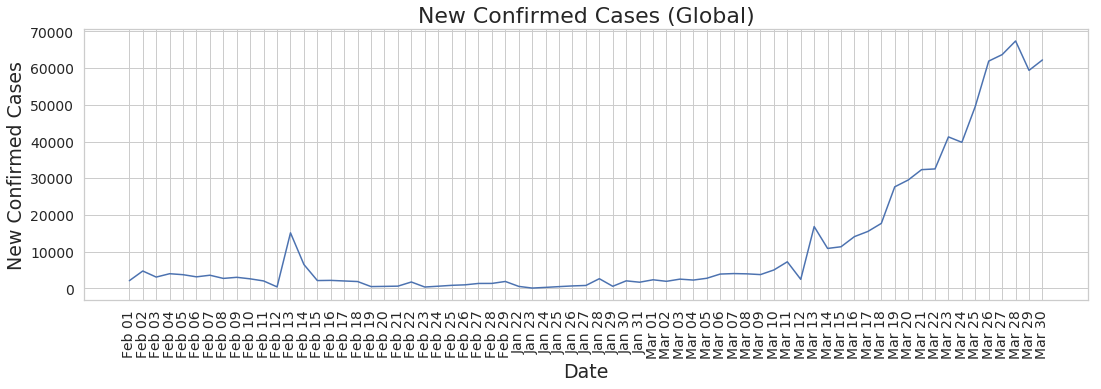

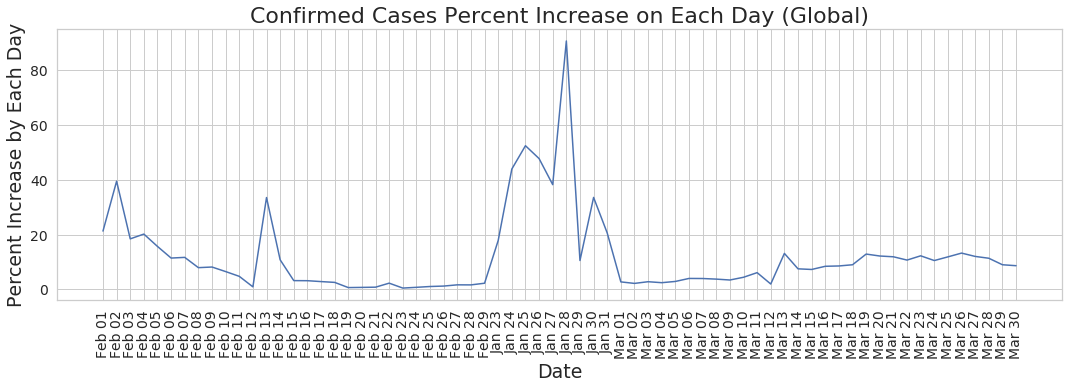

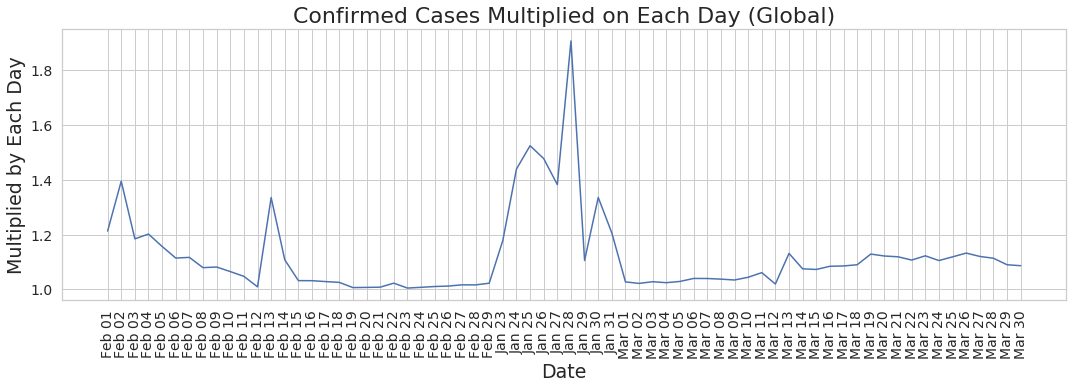

In [60]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

figsize   = (18, 5)
params    = {'figure.figsize' : figsize,
             'axes.labelsize' : labelsize,
             'axes.titlesize' : titlesize,
             'xtick.labelsize': ticksize,
             'ytick.labelsize': ticksize}

plt.rcParams.update(params)


title    = "New Confirmed Cases (Global)"

xlabel   = "Date"
ylabel   = "New Confirmed Cases"

rotation = 90

sns.lineplot(y = confirmed_total_add.values-1, x = data_cols)

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



title    = "Confirmed Cases Percent Increase on Each Day (Global)"

xlabel   = "Date"
ylabel   = "Percent Increase by Each Day"

rotation = 90

sns.lineplot(y=confirmed_total_percent_inc.values[1:], x=data_cols[1:])

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



title    = "Confirmed Cases Multiplied on Each Day (Global)"

xlabel   = "Date"
ylabel   = "Multiplied by Each Day"

rotation = 90

sns.lineplot(y=confirmed_total_mul.values[1:], x=data_cols[1:])

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



# title    = "New Confirmed Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90

# sns.barplot(y=confirmed_total_inc.values[1:], x=data_cols[1:])
# plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
# plt.show() 

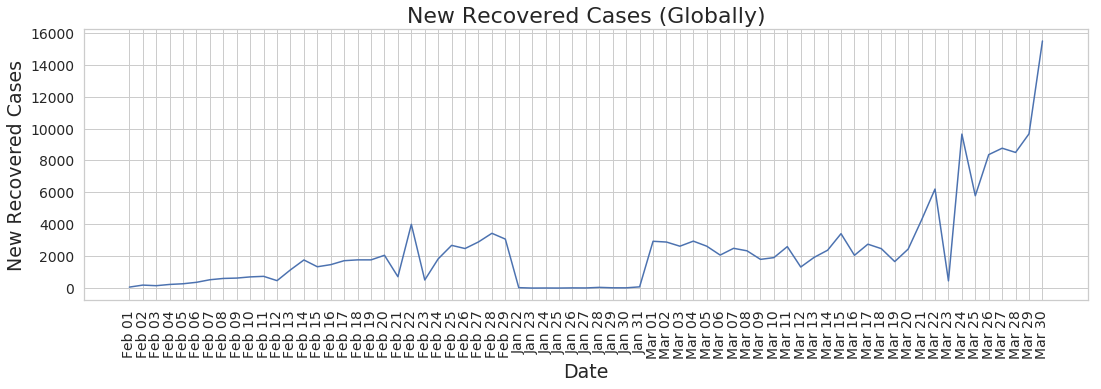

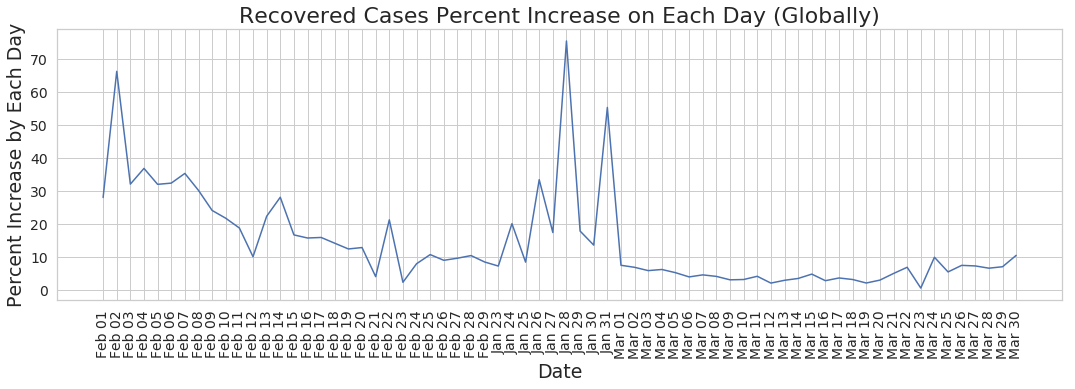

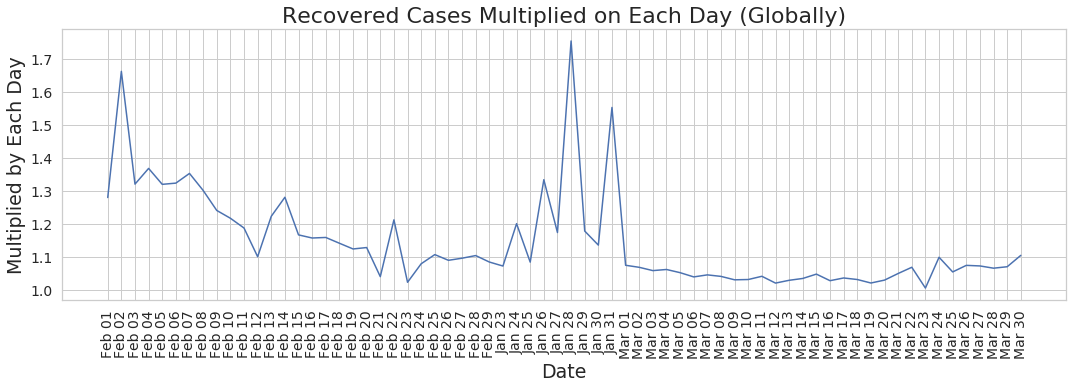

In [61]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize   = (18, 5)
params    = {'figure.figsize' : figsize,
             'axes.labelsize' : labelsize,
             'axes.titlesize' : titlesize,
             'xtick.labelsize': ticksize,
             'ytick.labelsize': ticksize}

plt.rcParams.update(params)


title    = "New Recovered Cases (Globally)"

xlabel   = "Date"
ylabel   = "New Recovered Cases"

rotation = 90


sns.lineplot(y = recovered_total_add.values, x = data_cols)

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



title    = "Recovered Cases Percent Increase on Each Day (Globally)"

xlabel   = "Date"
ylabel   = "Percent Increase by Each Day"

rotation = 90

sns.lineplot(y=recovered_total_percent_inc.values[1:], x=data_cols[1:])

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



title    = "Recovered Cases Multiplied on Each Day (Globally)"

xlabel   = "Date"
ylabel   = "Multiplied by Each Day"

rotation = 90

sns.lineplot(y=recovered_total_mul.values[1:], x=data_cols[1:])

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



# title    = "New Recovered Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90

# sns.barplot(y=recovered_total_inc.values[1:], x=data_cols[1:])
# plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
# plt.show() 

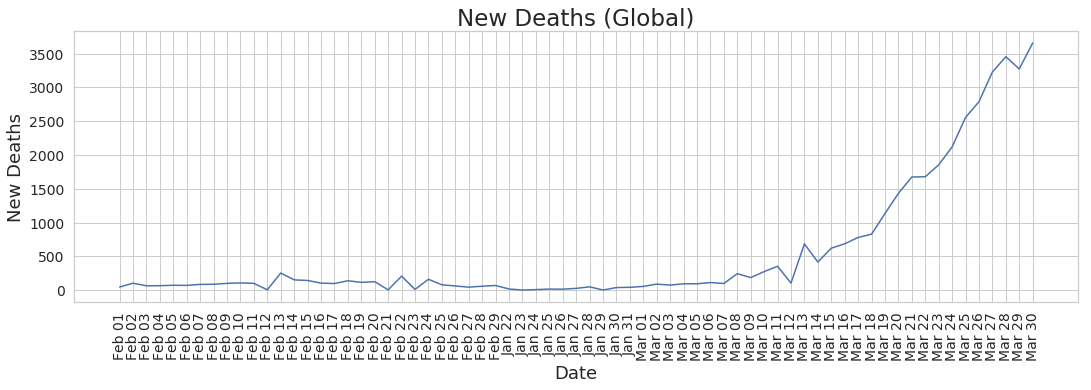

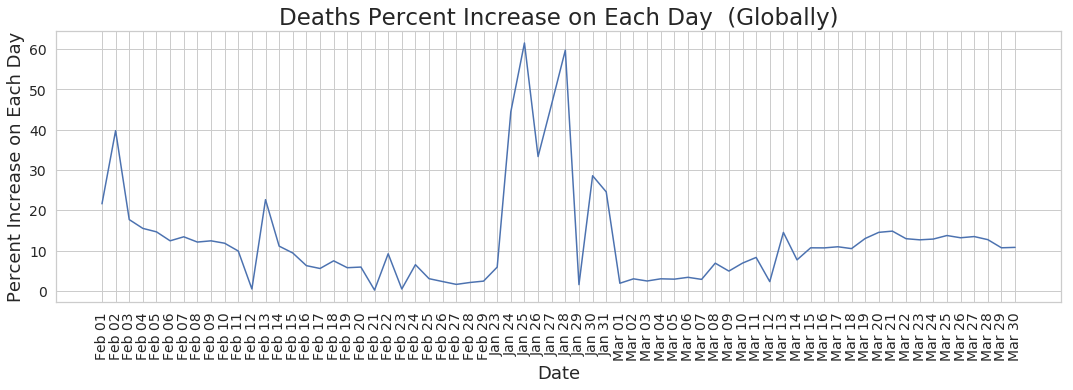

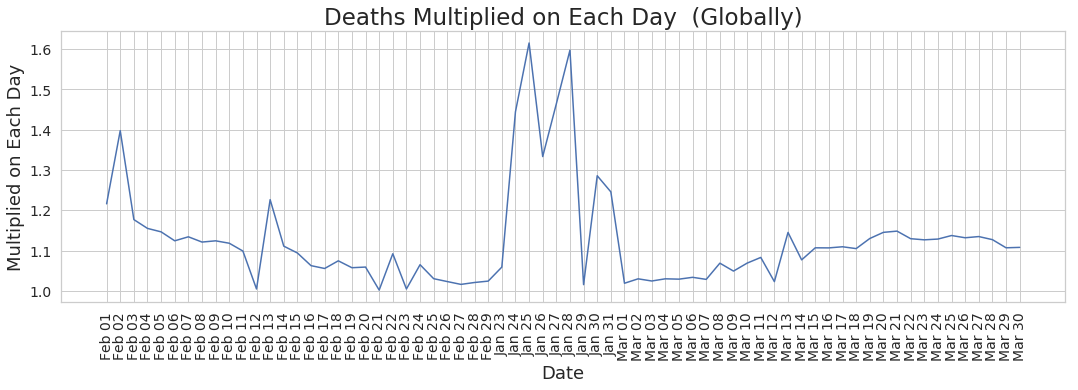

In [62]:
sns.set(style="whitegrid")

ticksize  = 14
labelsize = int(ticksize * 1.3)
titlesize = int(labelsize * 1.3)

figsize   = (18, 5)
params    = {'figure.figsize' : figsize,
             'axes.labelsize' : labelsize,
             'axes.titlesize' : titlesize,
             'xtick.labelsize': ticksize,
             'ytick.labelsize': ticksize}

plt.rcParams.update(params)


title    = "New Deaths (Global)"
xlabel   = "Date"
ylabel   = "New Deaths"
rotation = 90

sns.lineplot(y = death_total_add.values, x = data_cols)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=rotation)
plt.show() 



title    = "Deaths Percent Increase on Each Day  (Globally)"
xlabel   = "Date"
ylabel   = "Percent Increase on Each Day"
rotation = 90

sns.lineplot(y=death_total_percent_inc.values[1:], x=data_cols[1:])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=rotation)
plt.show() 



title    = "Deaths Multiplied on Each Day  (Globally)"
xlabel   = "Date"
ylabel   = "Multiplied on Each Day"
rotation = 90

sns.lineplot(y=death_total_mul.values[1:], x=data_cols[1:])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=rotation)
plt.show() 



# title    = "New Deaths Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90

# sns.barplot(y=death_total_inc.values[1:], x=data_cols[1:])
# plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
# plt.show() 

In [63]:
x_col = "Country/Region"
y_col = "Confirmed"
title = "Total Confirm Count"


df = result_country[[x_col, y_col]].sort_values(by=y_col, ascending=False).reset_index()
# df

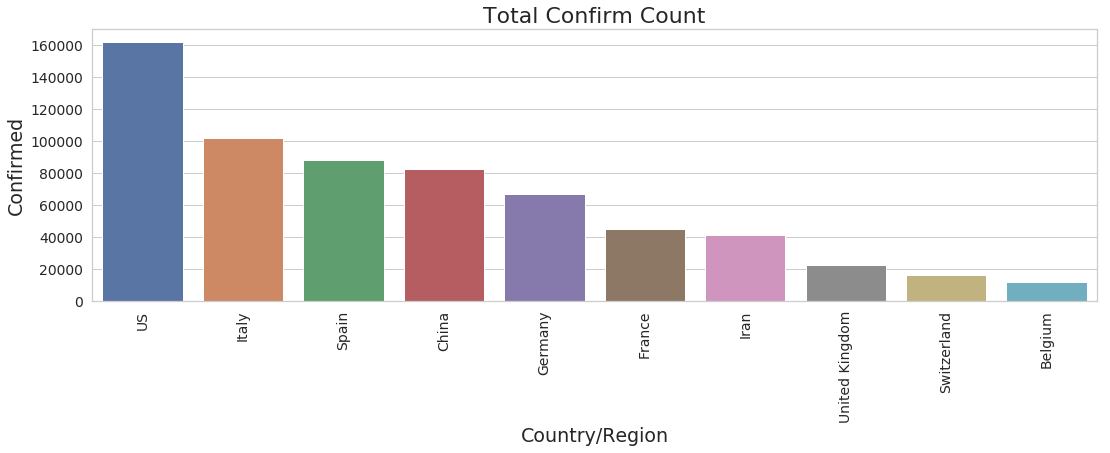

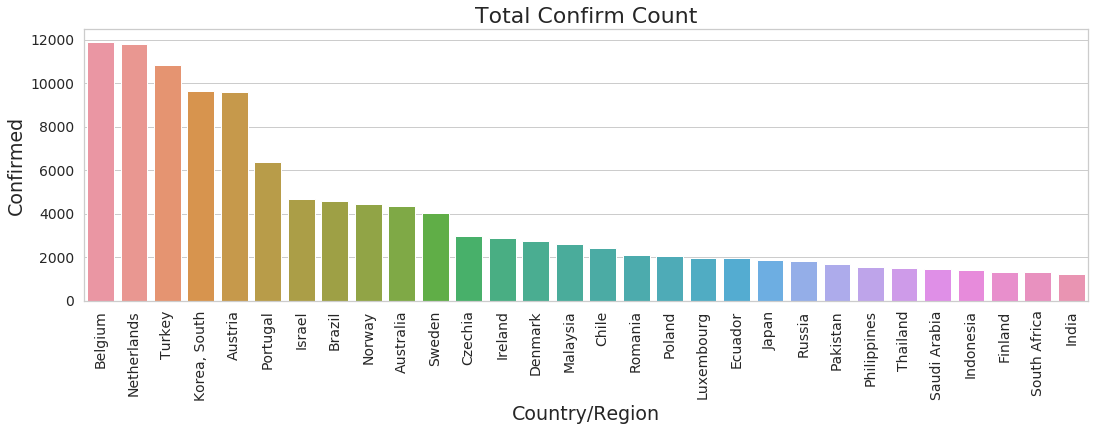

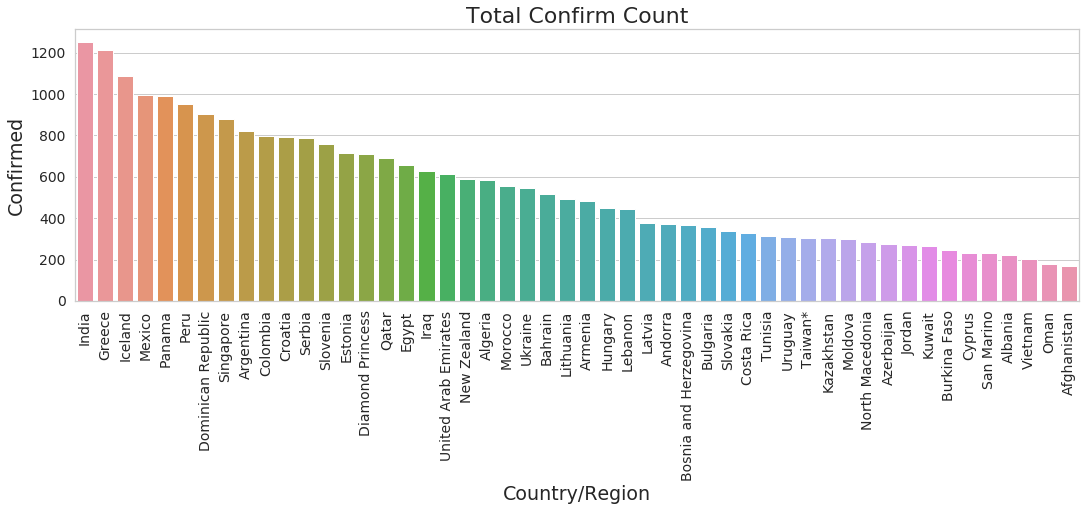

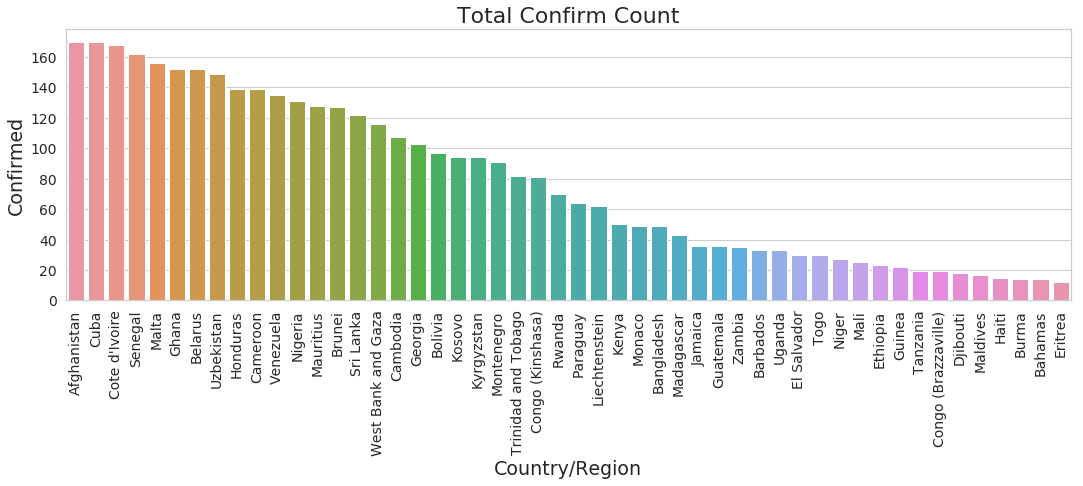

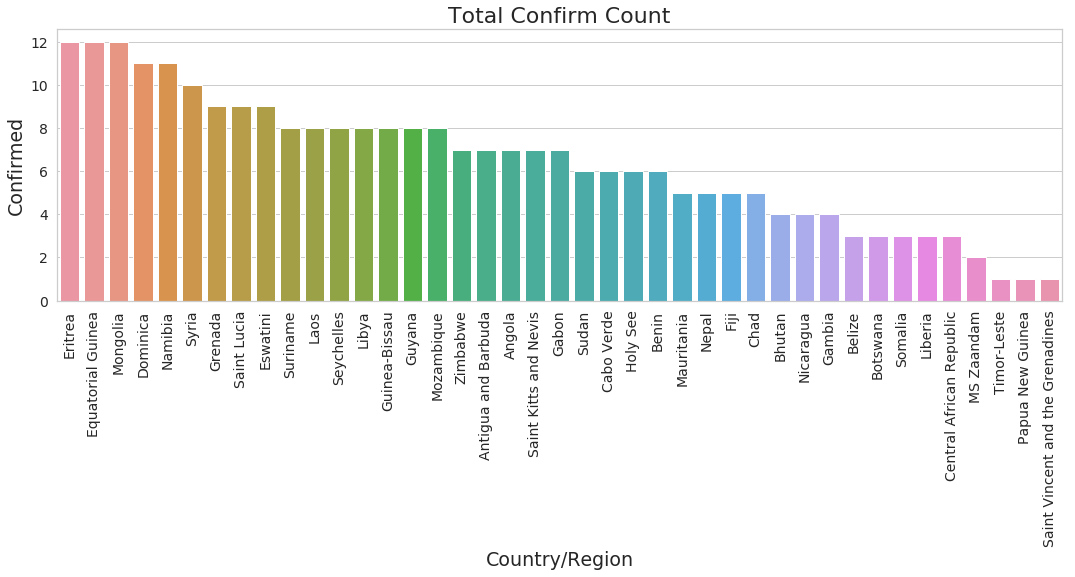

In [64]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Confirmed"
title = "Total Confirm Count"


df = result_country[[x_col, y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 10
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 




start = max_count - 1
max_count = 30

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 

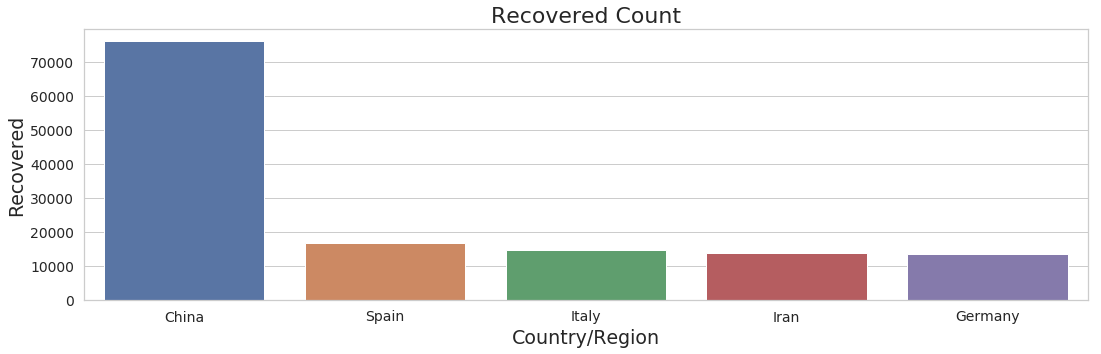

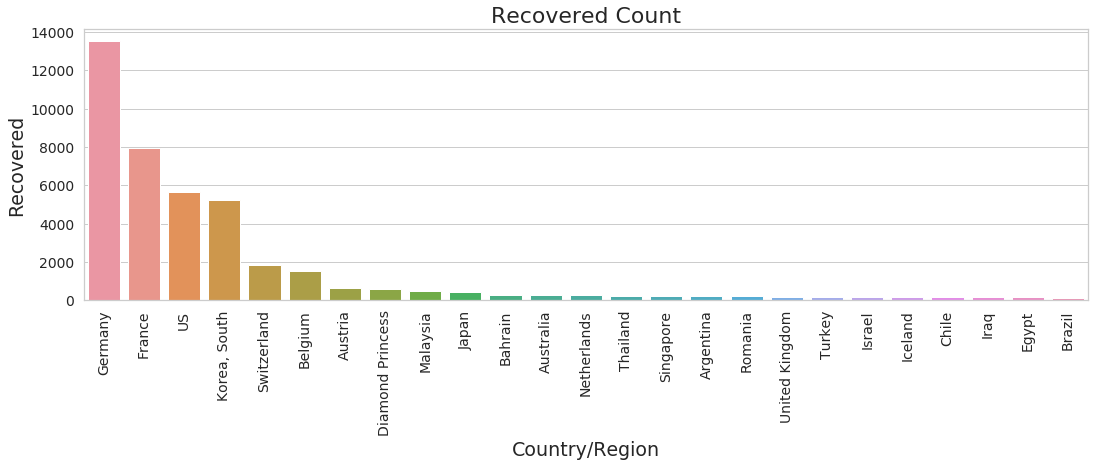

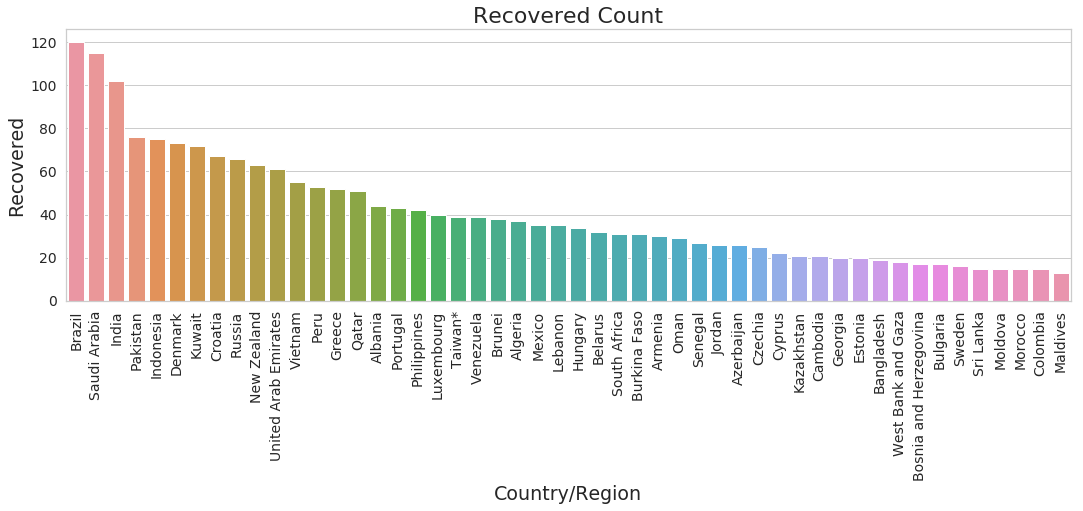

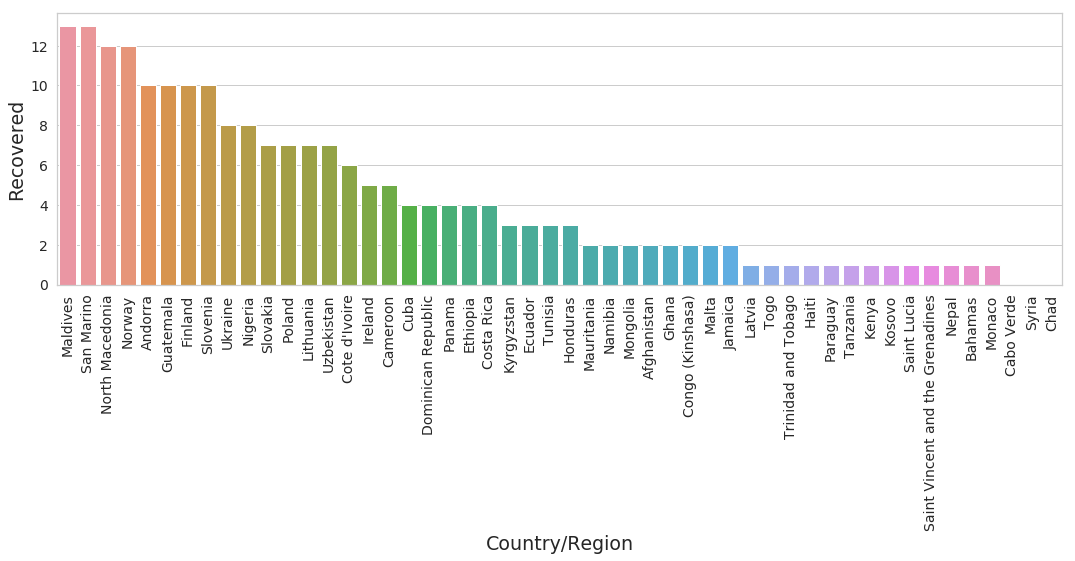

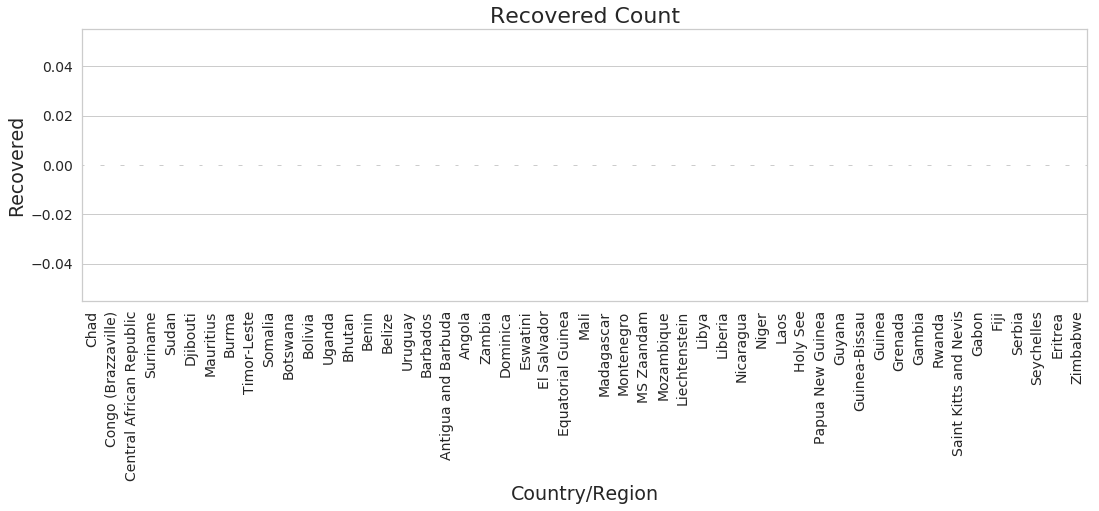

In [65]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Recovered"
title = "Recovered Count"


df = result_country[[x_col, y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 5
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
# plt.xticks(rotation=90)
plt.show() 




start = max_count - 1
max_count = 25

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
# plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


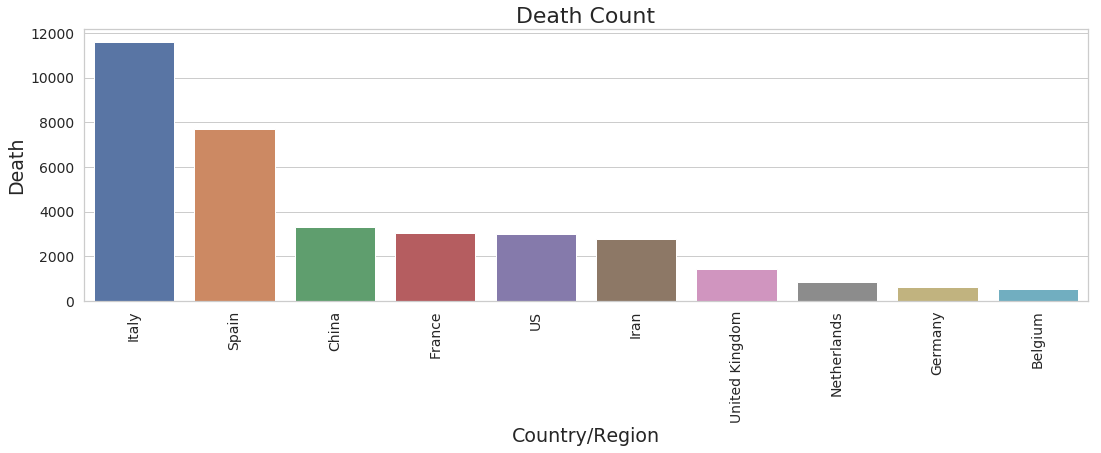

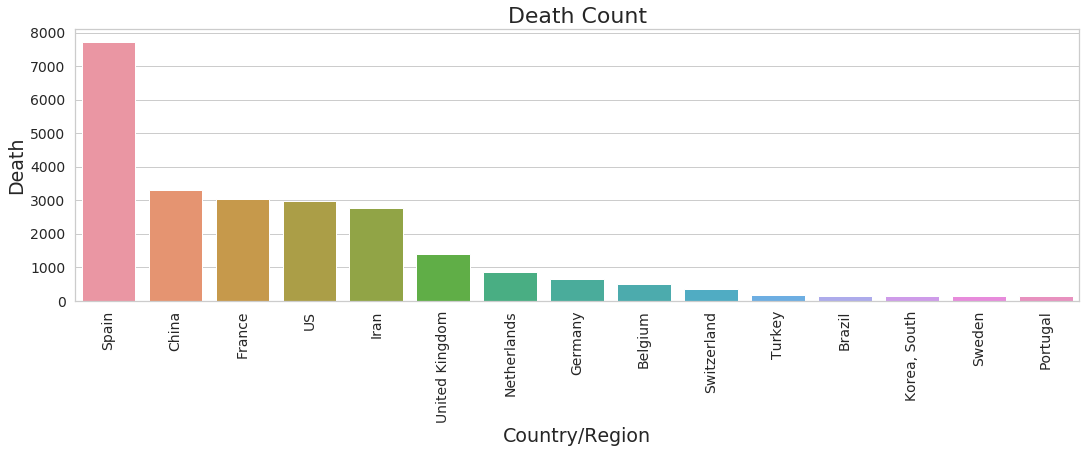

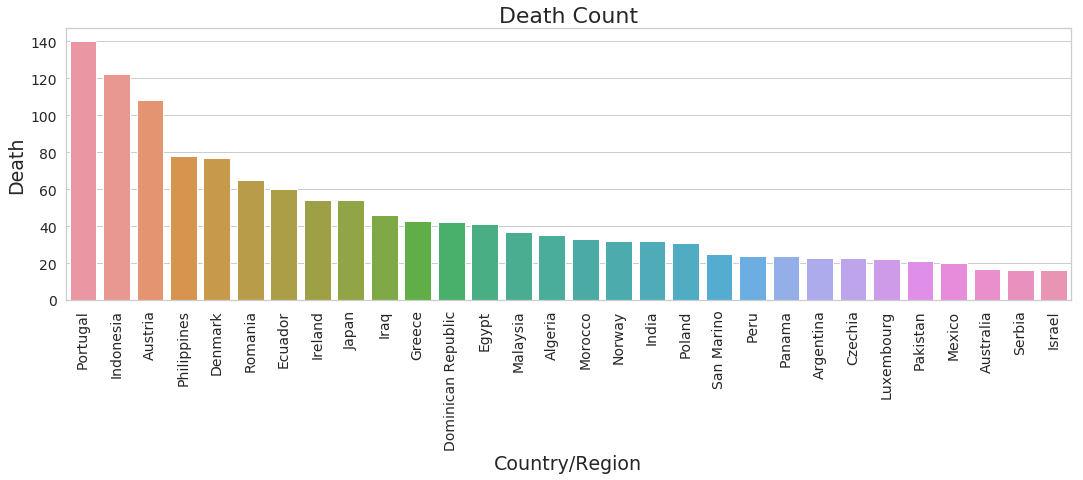

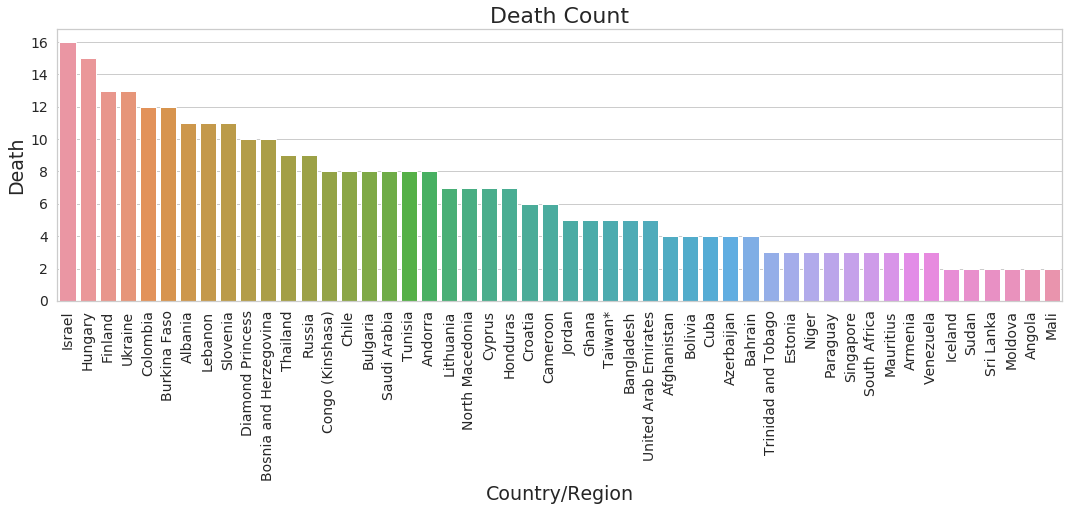

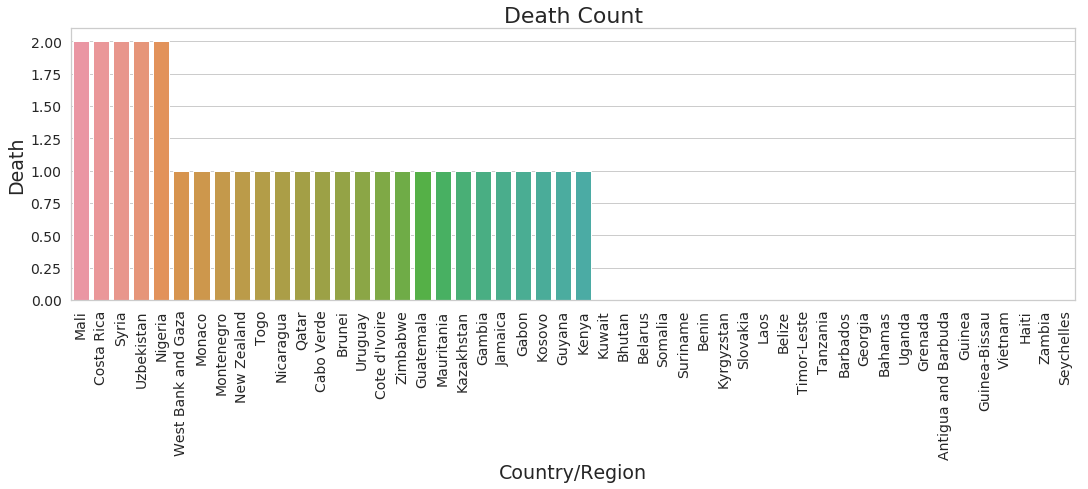

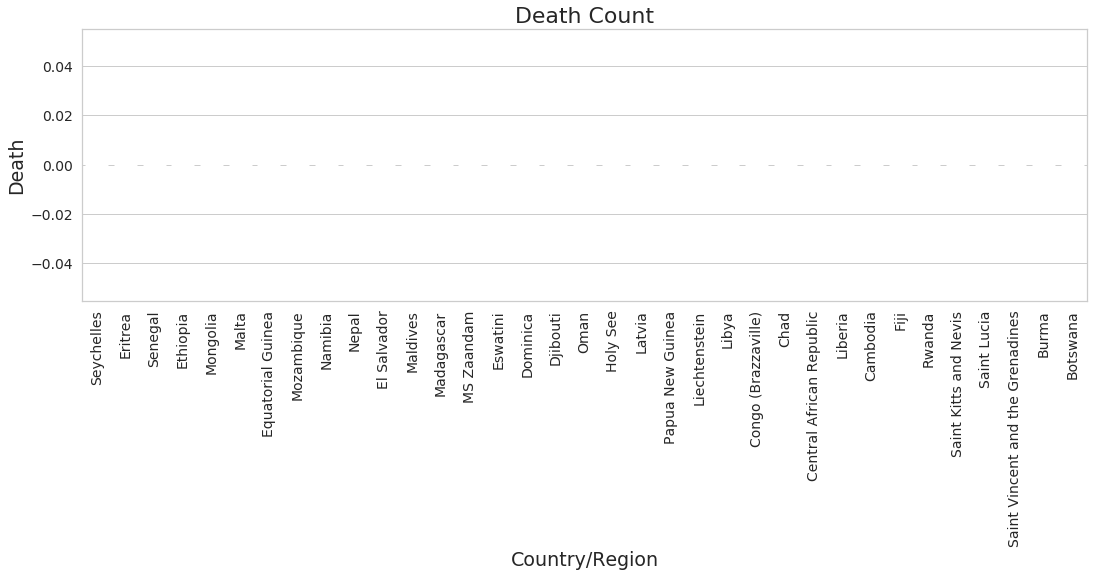

In [66]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Death"
title = "Death Count"


df = result_country[[x_col, y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 10
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 




start = 1
max_count = 15

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 30

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 

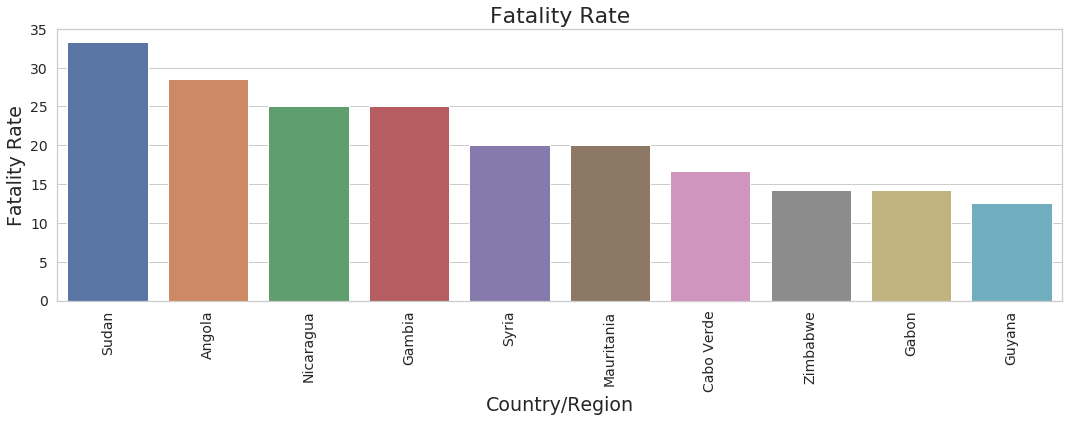

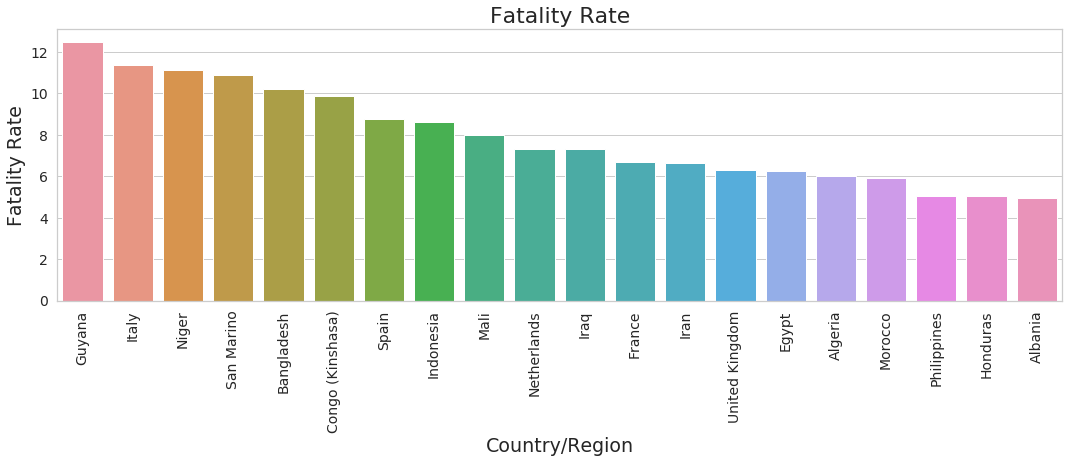

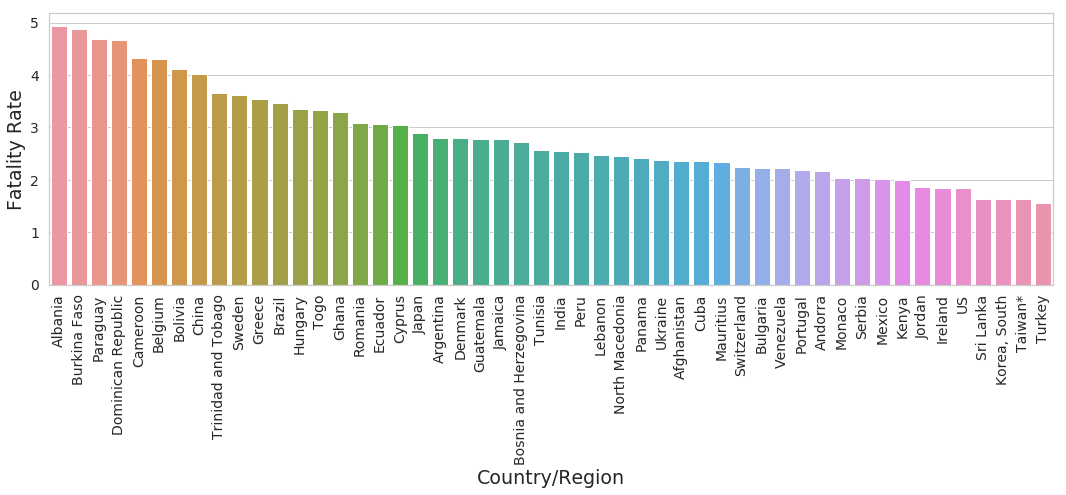

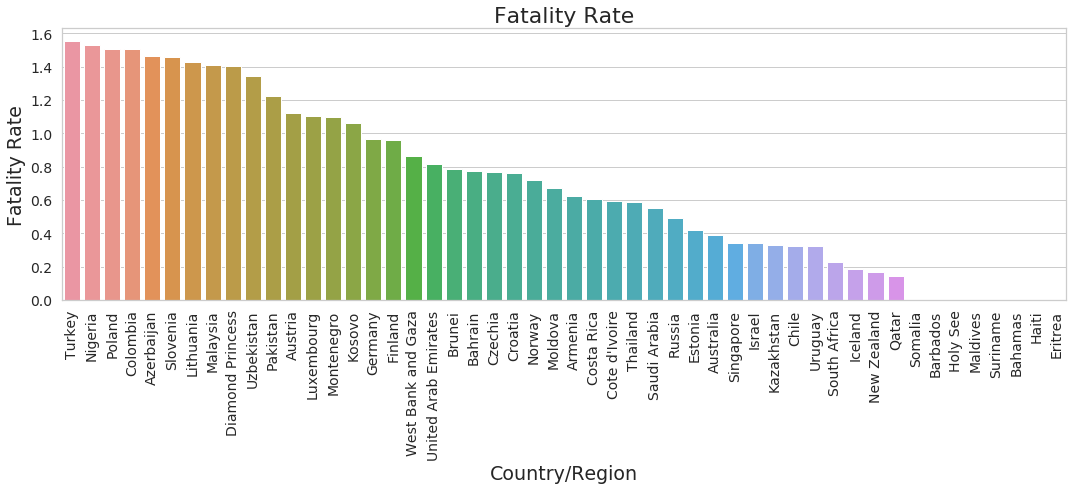

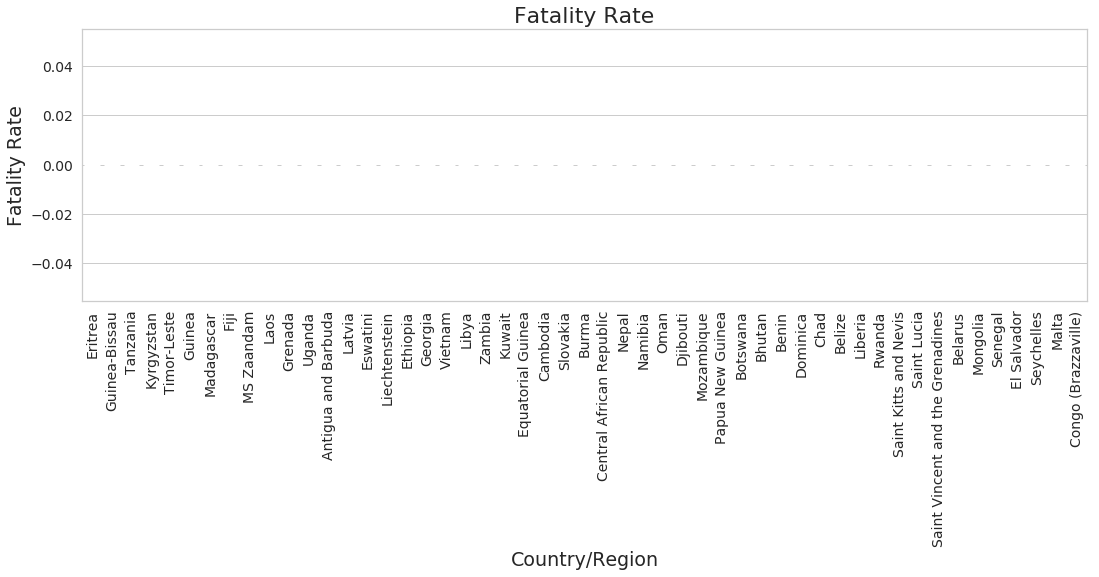

In [67]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Fatality Rate"
title = "Fatality Rate"


df = result_country[[x_col, y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 10
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 




start = max_count - 1
max_count = 20

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
# plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


# start = start + max_count - 1
# max_count = 50

# sns.barplot(x=x_col, y=y_col, data=df[start: ])
# plt.title(title)
# plt.xticks(rotation=90)
# plt.show() 

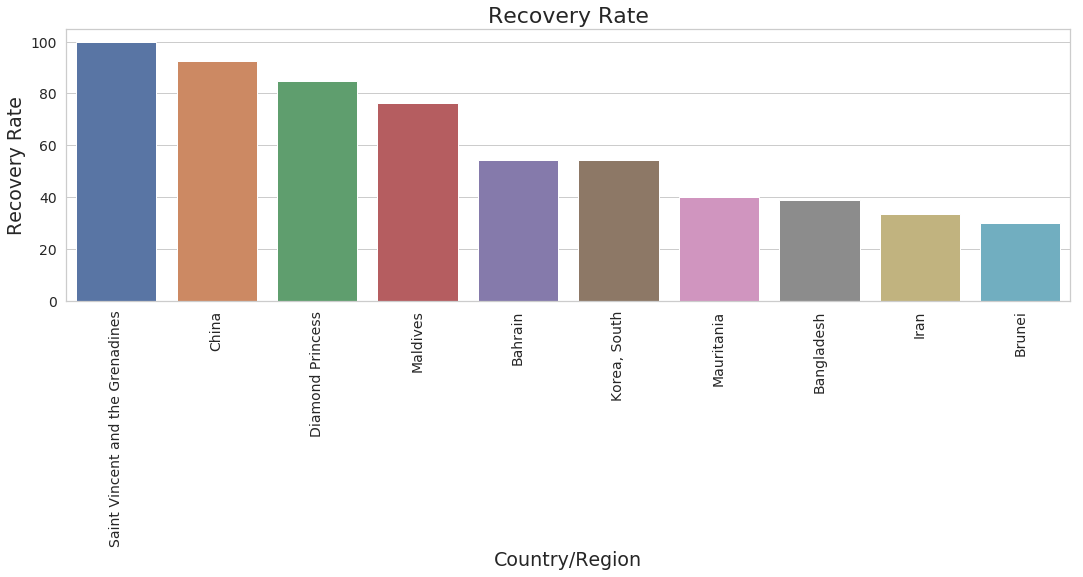

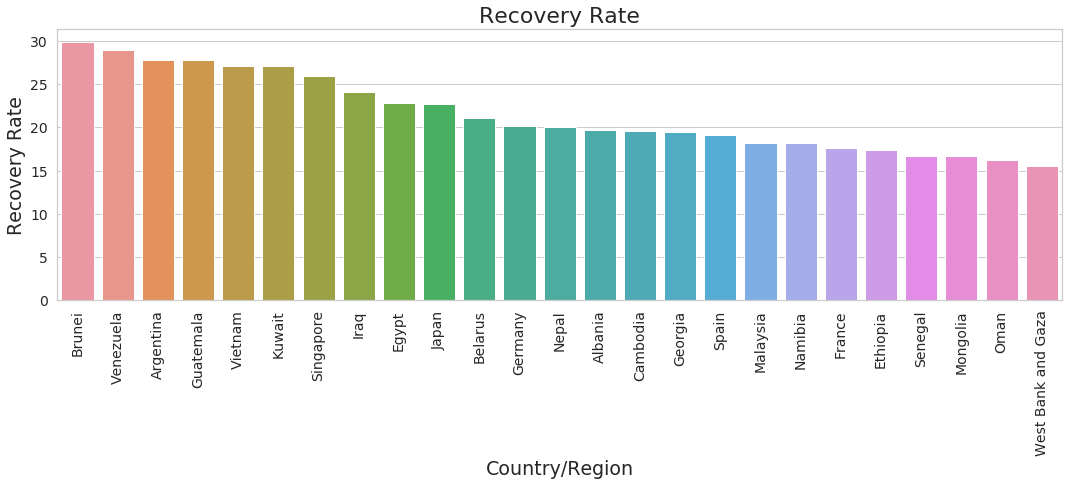

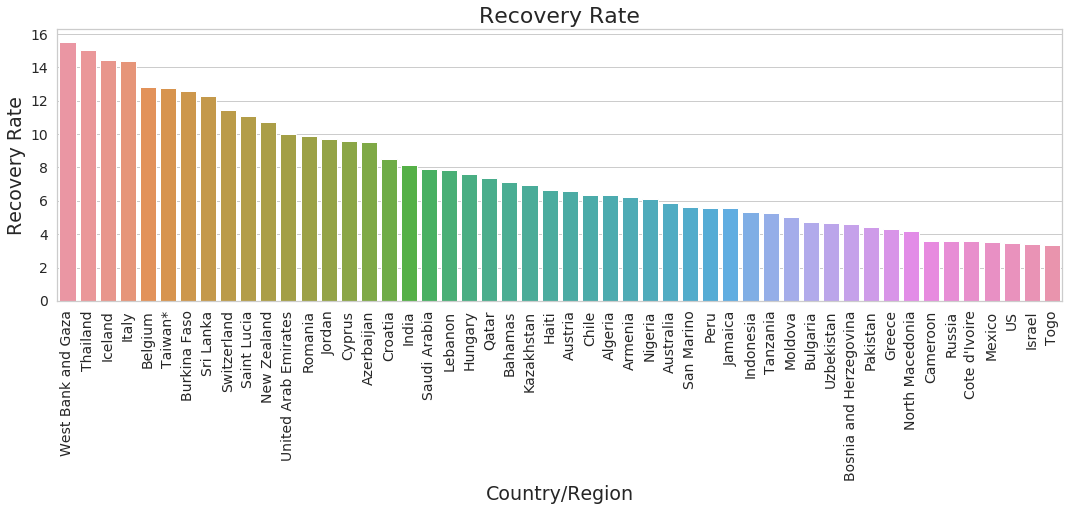

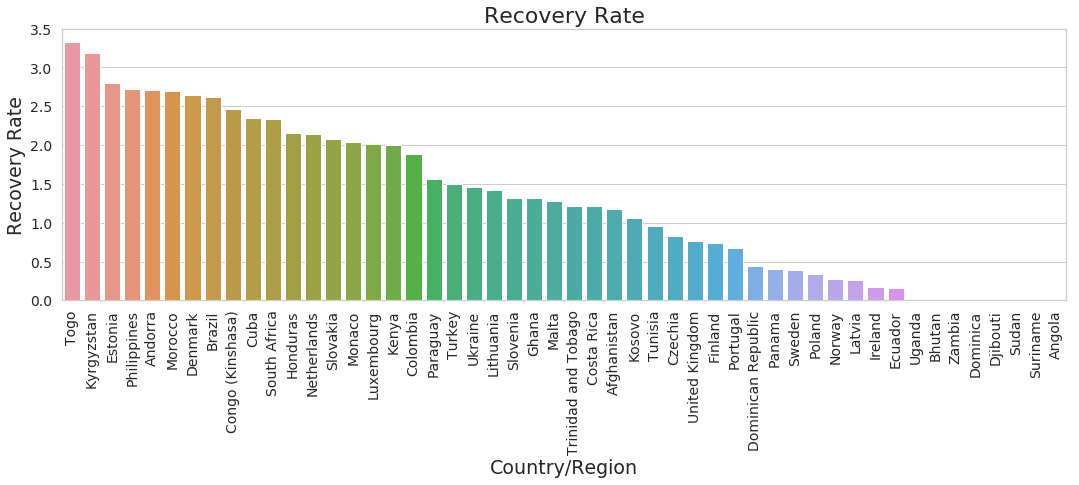

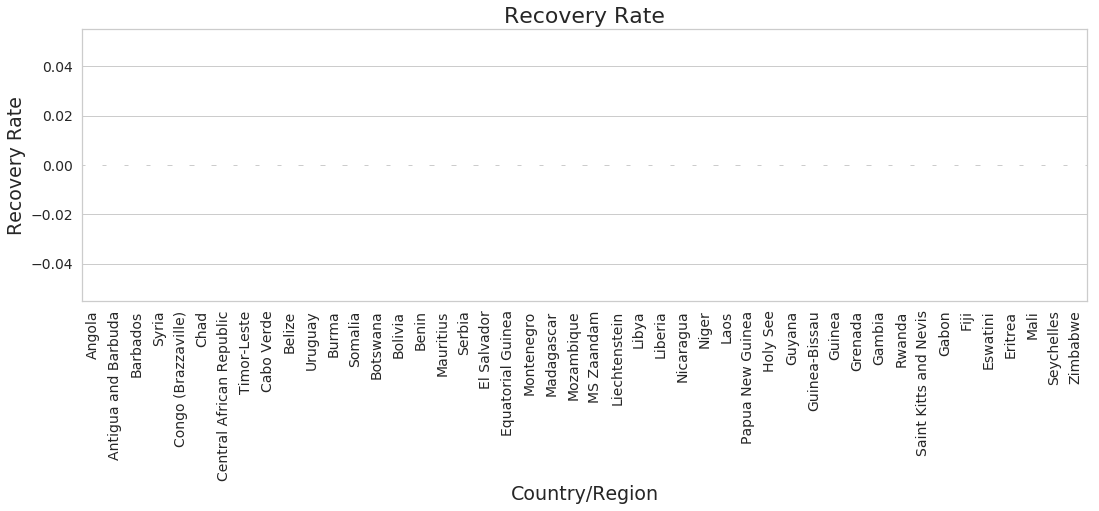

In [68]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Recovery Rate"
title = "Recovery Rate"


df = result_country[[x_col, y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 10
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 




start = max_count - 1
max_count = 25

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 

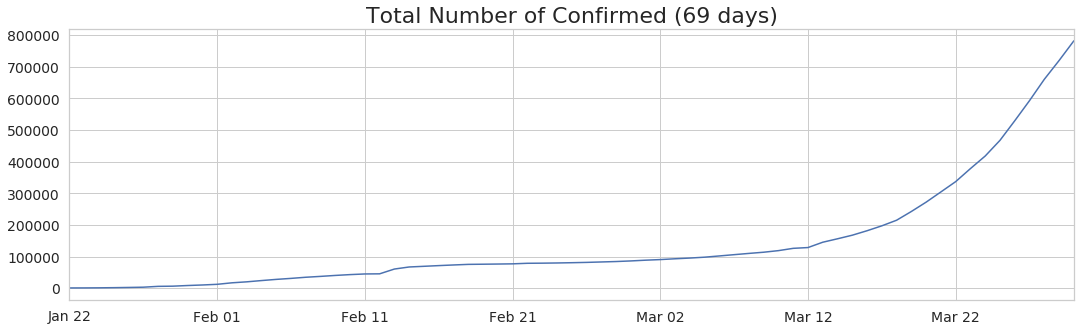

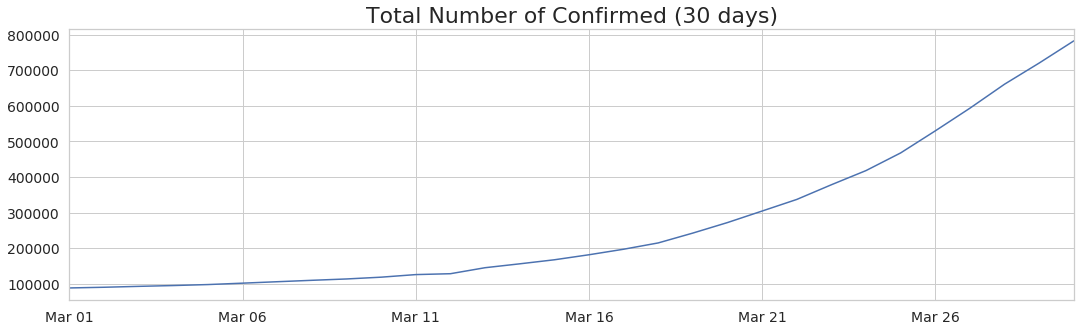

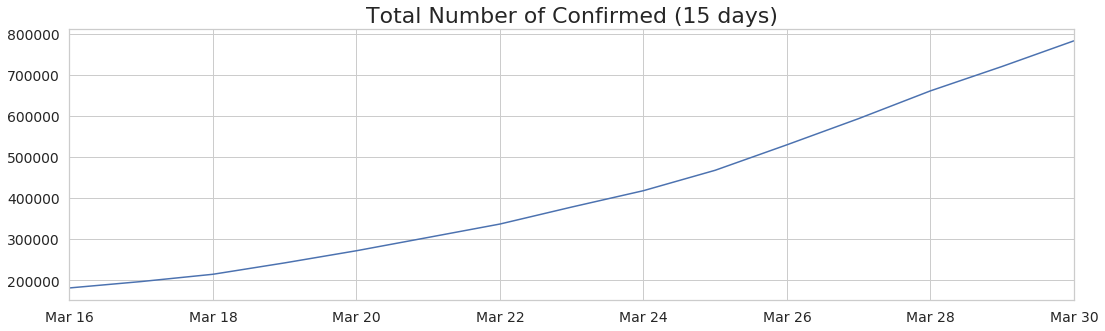

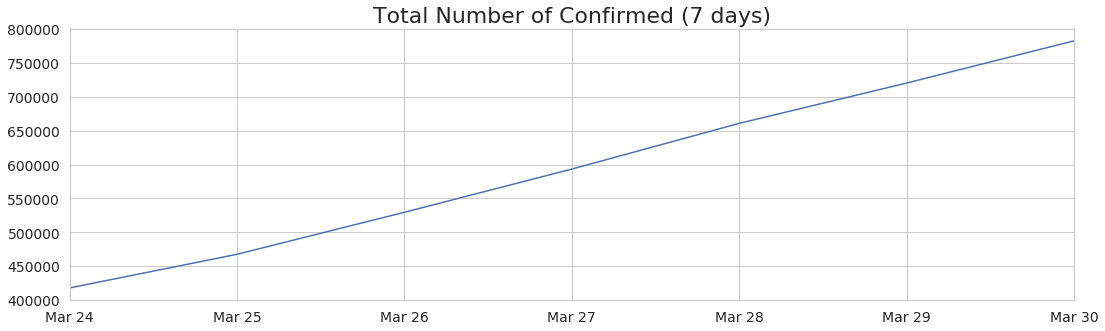

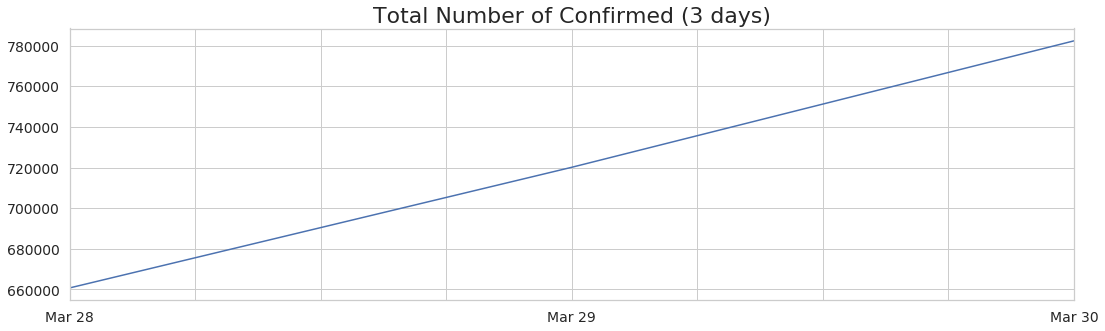

In [69]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


count_days_vis = {len(data_cols): "line", 30: "line", 15: "line", 7: "line", 3: "line"}

df = time_series_covid_19_confirmed
title_key = " Confirmed "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

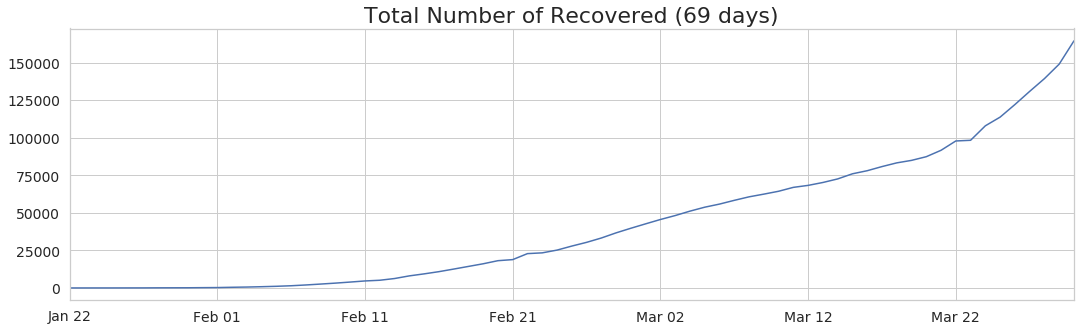

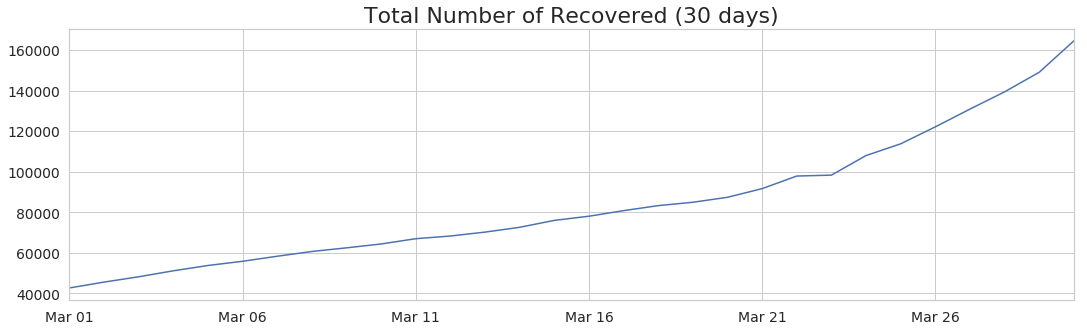

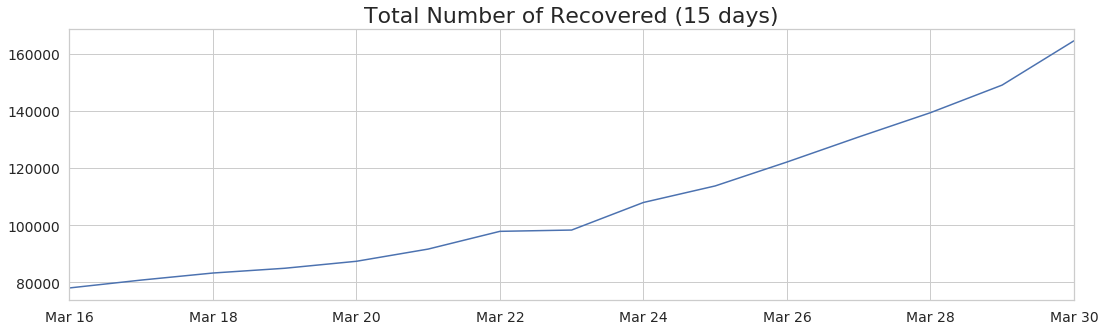

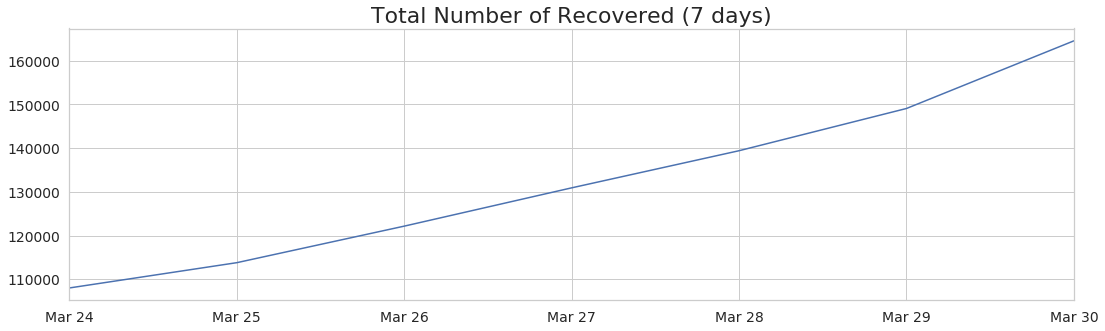

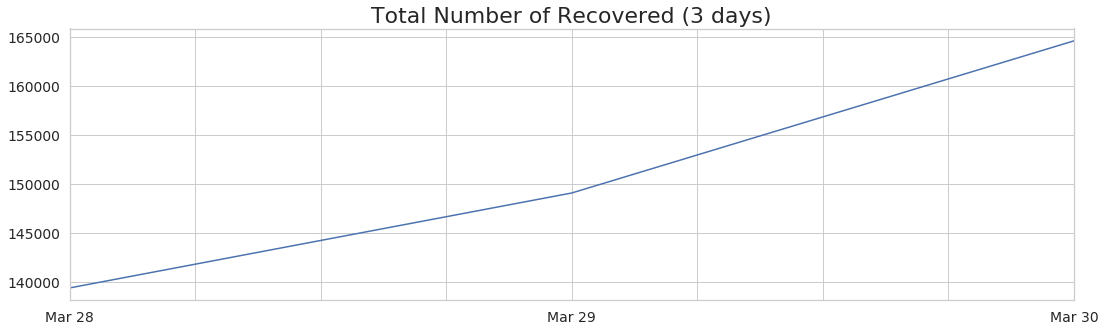

In [70]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


count_days_vis = {len(data_cols): "line", 30: "line", 15: "line", 7: "line", 3: "line"}

df = time_series_covid_19_recovered
title_key = " Recovered "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

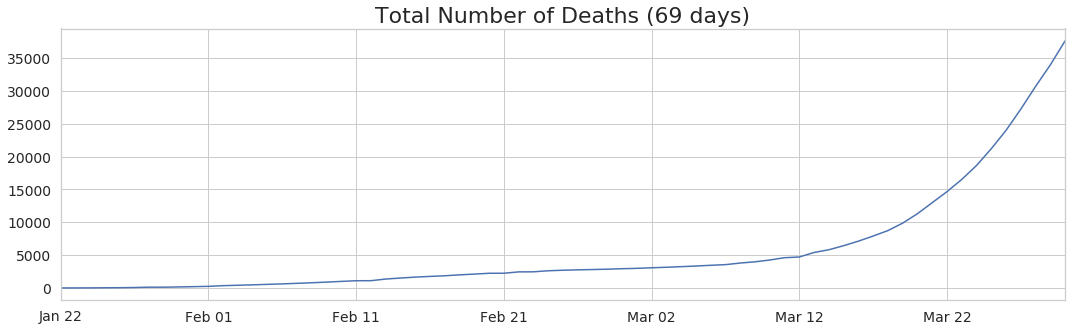

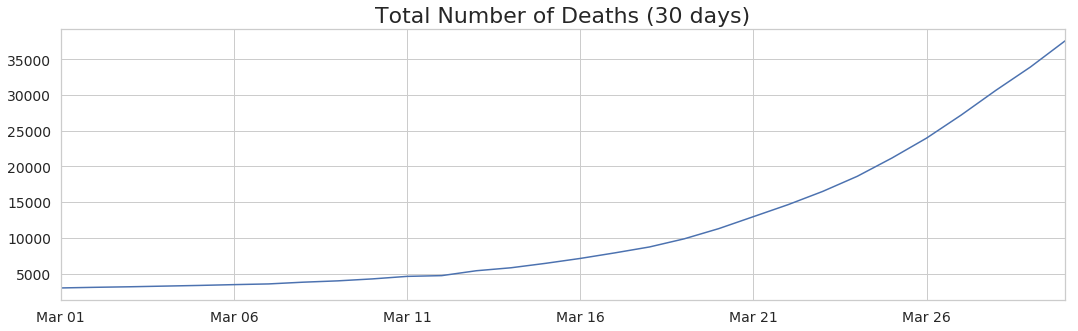

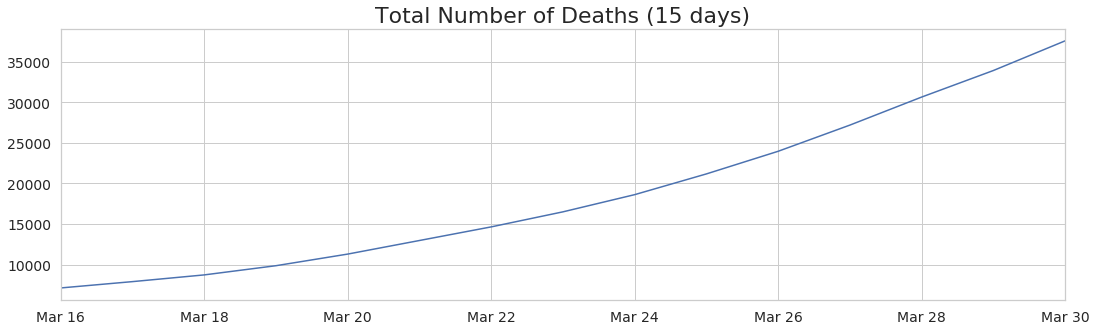

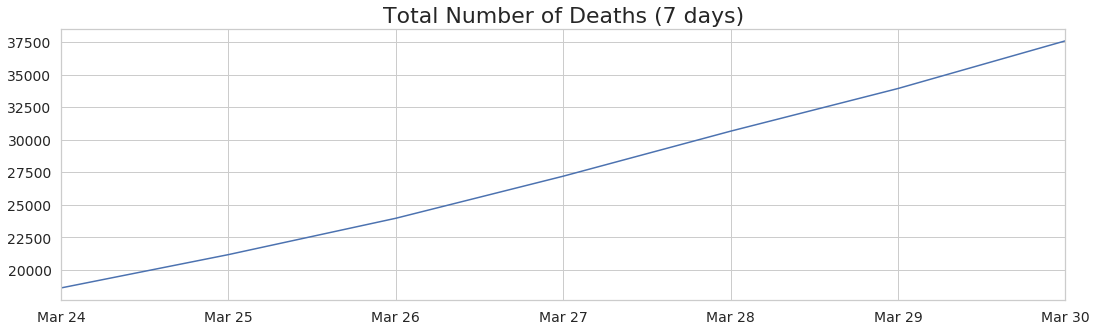

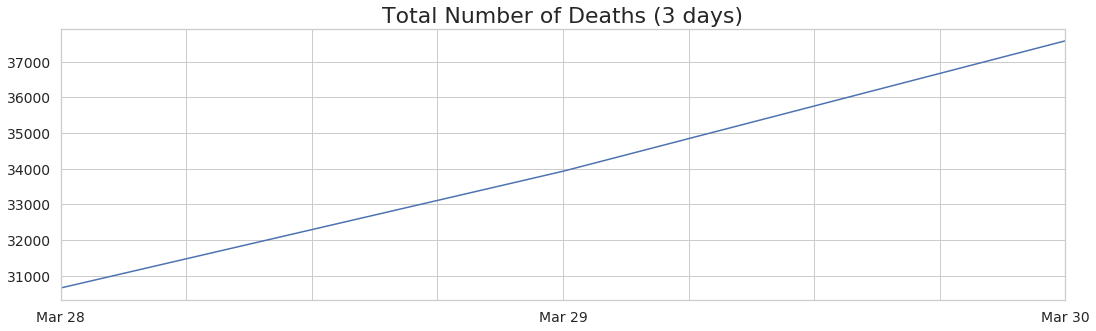

In [71]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

count_days_vis = {len(data_cols): "line", 30: "line", 15: "line", 7: "line", 3: "line"}


df = time_series_covid_19_deaths
title_key = " Deaths "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

In [72]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Confirmed Cases"
# xlabel   = "Date"
# ylabel   = "New Confirmed Cases"
# rotation = 90


# for index, row in confirmed_country_add.iterrows():
#     sns.barplot(y = row[data_cols].values, x = data_cols)
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 


In [73]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "Confirmed Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90


# for index, row in confirmed_country_mul.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [74]:
# sns.set(style="whitegrid")

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Confirmed Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90


# for index, row in confirmed_country_inc.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [75]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Recovered Cases"
# xlabel   = "Date"
# ylabel   = "New Recovered Cases"
# rotation = 90


# for index, row in recovered_country_add.iterrows():
#     sns.barplot(y = row[data_cols].values, x = data_cols)
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 


In [76]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "Recovered Cases Multiplied on Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied on Each Day"
# rotation = 90


# for index, row in recovered_country_mul.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [77]:
# sns.set(style="whitegrid")

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Recovered Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90


# for index, row in recovered_country_inc.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [78]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Deaths"
# xlabel   = "Date"
# ylabel   = "New Deaths"
# rotation = 90


# for index, row in death_country_add.iterrows():
#     sns.barplot(y = row[data_cols].values, x = data_cols)
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 


In [79]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "Deaths Multiplied on Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied on Each Day"
# rotation = 90


# for index, row in death_country_mul.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [80]:
# sns.set(style="whitegrid")

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Death Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90


# for index, row in death_country_inc.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [81]:
# time_series_covid_19_confirmed[data_cols].fillna(0, inplace=True)
# time_series_covid_19_recovered[data_cols].fillna(0, inplace=True)
# time_series_covid_19_deaths[data_cols].fillna(0, inplace=True)

In [82]:
# from mpl_toolkits.basemap import Basemap

# plt.figure(figsize=(8, 8))
# m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
# m.bluemarble(scale=0.5);


In [83]:
# # cities = pd.read_csv('data/california_cities.csv')

# df = time_series_covid_19_confirmed
# # Extract the data we're interested in
# lat = df['Lat'].values
# lon = df['Long'].values
# confirm_last = df[last_day].values
# # area = cities['area_total_km2'].values

In [84]:
# # 1. Draw the map background
# fig = plt.figure(figsize=(8, 8))
# m = Basemap(projection='lcc', resolution='h', 
#             lat_0=37.5, lon_0=-119,
#             width=1E6, height=1.2E6)
# m.shadedrelief()
# m.drawcoastlines(color='gray')
# m.drawcountries(color='gray')
# m.drawstates(color='gray')

# # 2. scatter city data, with color reflecting population
# # and size reflecting area
# m.scatter(lon, lat, latlon=True,
#           c=np.log10(population),
#           cmap='Reds', alpha=0.5)

# # 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm population})$')
# plt.clim(3, 7)

# # make legend with dummy points
# for a in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');